In [25]:
# define logging and working directory
from ProjectRoot import change_wd_to_project_root
change_wd_to_project_root()
from src.utils.Notebook_imports import *
#from pyforest import *
from src.utils.Tensorflow_helper import choose_gpu_by_id
from tensorflow.keras.utils import plot_model
from tensorflow.python.client import device_lib
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
import cv2
# define GPU id to use
GPU_IDS = '0,1'
GPUS = choose_gpu_by_id(GPU_IDS)
print(GPUS)

# jupyter magic config
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# import helpers
from src.utils.Utils_io import Console_and_file_logger, init_config
from src.visualization.Visualize import show_2D_or_3D
from src.data.Dataset import get_img_msk_files_from_split_dir, load_acdc_files, get_train_data_from_df, get_trainings_files
from src.data.Generators import DataGenerator, get_samples, CycleMotionDataGenerator
from src.utils.KerasCallbacks import get_callbacks
import src.utils.Metrics_own as metr
import src.models.SpatialTransformer as st
from src.models.SpatialTransformer import create_affine_cycle_transformer_model
from src.models.ModelUtils import load_pretrained_model

# path params
ARCHITECTURE = '3D' # 2D
DATASET = 'GCN'  # 'acdc' # or 'gcn'
FOLD = 2 # CV fold 0-3

# Define an experiment name, could have subfolder conventions
EXP_NAME = 'ax_sax/unetwithdownsamplingaugmentation_new_data'

# Uniform path names, separation of concerns
EXPERIMENT = '{}/{}'.format(ARCHITECTURE, EXP_NAME)
timestemp = str(datetime.datetime.now().strftime("%Y-%m-%d_%H_%M"))
#TRAIN_PATH = 'data/raw/{}/{}/train/'.format(DATASET, ARCHITECTURE)
#VAL_PATH = 'data/raw/{}/{}/val/'.format(DATASET, ARCHITECTURE)
#TEST_PATH = 'data/raw/{}/{}/val/'.format(DATASET, ARCHITECTURE)

DATA_PATH = '/mnt/ssd/data/gcn/ax_sax_from_flo/AX_3D/' # for cv
DATA_PATH_AX2SAX = DATA_PATH.replace('AX_3D', 'AX_to_SAX_3D')
DF_PATH = '/mnt/ssd/data/gcn/gcn_05_2020_ax_sax_86/folds.csv'

MODEL_PATH = os.path.join('models', EXPERIMENT, timestemp)
TENSORBOARD_LOG_DIR = os.path.join('reports/tensorboard_logs', EXPERIMENT,timestemp)
CONFIG_PATH = os.path.join('reports/configs/',EXPERIMENT,timestemp)
HISTORY_PATH = os.path.join('reports/history/',EXPERIMENT,timestemp)

# Hyperparameters and experiment definition, to avoid code changes and parameter combinations compareable
DIM = [72, 112, 112] # network input params for spacing of 3, (z,y,x)
DEPTH = 4 # number of down-/upsampling blocks
FILTERS = 16 # initial number of filters, will be doubled after each downsampling block
SPACING = [3,3, 3] # if resample, resample to this spacing, (z,y,x)
M_POOL = [2, 2, 2]# used for downsampling and upsampling
F_SIZE = [3, 3, 3] # conv filter size
IMG_CHANNELS = 1 # Currently our model needs that image channel
MASK_VALUES = [1, 2, 3]  #channel order: Background, RV, MYO, LV
MASK_CLASSES = len(MASK_VALUES) # no of labels
BORDER_MODE = cv2.BORDER_REFLECT_101
IMG_INTERPOLATION = cv2.INTER_LINEAR
MSK_INTERPOLATION = cv2.INTER_NEAREST
AUGMENT = False
SHUFFLE = True
AUGMENT_GRID = False
RESAMPLE = True
SCALER = 'MinMax' # MinMax Standard or Robust

AX_LOSS_WEIGHT = 1.0
WEIGHT_MSE_INPLANE = True
MASK_SMALLER_THAN_THRESHOLD = 0.001

SAX_LOSS_WEIGHT = 1.0
CYCLE_LOSS = True

FOCUS_LOSS_WEIGHT = 1.0
FOCUS_LOSS = True
USE_SAX2AX_PROB = False
MIN_UNET_PROBABILITY = 0.8

# training params
GENERATOR_WORKER = 2 # if not set, use batchsize
SEED = 42 # define a seed for the generator shuffle
BATCHSIZE = 2 # 32, 64, 24, 16, 1 for 3D use: 8
INITIAL_EPOCH = 0 # change this to continue training
EPOCHS = 300 # define a maximum numbers of epochs
EPOCHS_BETWEEN_CHECKPOINTS = 5
MONITOR_FUNCTION = 'val_loss'
MONITOR_MODE = 'min'
SAVE_MODEL_FUNCTION = 'val_loss'
SAVE_MODEL_MODE = 'min'
MODEL_PATIENCE = 20
BN_FIRST = False # decide if BN between Conv and activation or afterwards
BATCH_NORMALISATION = True # apply BN or not
USE_UPSAMPLE = True # otherwise use transpose
PAD = 'same' # padding strategy
KERNEL_INIT = 'he_normal' # conv weight initialisation
OPTIMIZER = 'adam' # Adam, Adagrad, RMSprop, Adadelta,  # https://keras.io/optimizers/
ACTIVATION = 'elu' # tf.keras.layers.LeakyReLU(), relu or any other non linear activation function
LEARNING_RATE = 1e-4 # start with a huge lr to converge fast
DECAY_FACTOR = 0.3 # Define a learning rate decay for the ReduceLROnPlateau callback
MIN_LR = 1e-10 # minimal lr, smaller lr does not improve the model
DROPOUT_min = 0.3 # lower dropout at the shallow layers
DROPOUT_max = 0.5 # higher dropout at the deep layers

metrics = [
    metr.dice_coef_labels,
    metr.dice_coef_myo,
    metr.dice_coef_lv,
    metr.dice_coef_rv
]


LOSS_FUNCTION = metr.bce_dice_loss

Console_and_file_logger(EXPERIMENT, logging.INFO)

# Define a config for param injection,
# save a serialized version, 
# make sure all paths exist
config = init_config(config=locals(), save=True)
print(config)

2020-12-01 18:08:43,015 INFO -------------------- Start --------------------
2020-12-01 18:08:43,015 INFO Working directory: /mnt/ssd/git/3d-mri-domain-adaption.
2020-12-01 18:08:43,016 INFO Log file: ./logs/3D/ax_sax/unetwithdownsamplingaugmentation_new_data.log
2020-12-01 18:08:43,016 INFO Log level for console: INFO


search for root_dir and set working directory
Working directory set to: /mnt/ssd/git/3d-mri-domain-adaption
['/gpu:0', '/gpu:1']
{'GPU_IDS': '0,1', 'GPUS': ['/gpu:0', '/gpu:1'], 'ARCHITECTURE': '3D', 'DATASET': 'GCN', 'FOLD': 2, 'EXP_NAME': 'ax_sax/unetwithdownsamplingaugmentation_new_data', 'EXPERIMENT': '3D/ax_sax/unetwithdownsamplingaugmentation_new_data', 'DATA_PATH': '/mnt/ssd/data/gcn/ax_sax_from_flo/AX_3D/', 'DATA_PATH_AX2SAX': '/mnt/ssd/data/gcn/ax_sax_from_flo/AX_to_SAX_3D/', 'DF_PATH': '/mnt/ssd/data/gcn/gcn_05_2020_ax_sax_86/folds.csv', 'MODEL_PATH': 'models/3D/ax_sax/unetwithdownsamplingaugmentation_new_data/2020-12-01_18_08', 'TENSORBOARD_LOG_DIR': 'reports/tensorboard_logs/3D/ax_sax/unetwithdownsamplingaugmentation_new_data/2020-12-01_18_08', 'CONFIG_PATH': 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation_new_data/2020-12-01_18_08', 'HISTORY_PATH': 'reports/history/3D/ax_sax/unetwithdownsamplingaugmentation_new_data/2020-12-01_18_08', 'DIM': [72, 112, 112], 'DE

# Check Tensorflow setup and available GPUs

In [26]:
from tensorflow.keras.mixed_precision import experimental as mixed_precision
logging.info('Is built with tensorflow: {}'.format(tf.test.is_built_with_cuda()))
logging.info('Visible devices:\n{}'.format(tf.config.list_physical_devices()))
logging.info('Local devices: \n {}'.format(device_lib.list_local_devices()))
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)
logging.info('Compute dtype: %s' % policy.compute_dtype)
logging.info('Variable dtype: %s' % policy.variable_dtype)

2020-12-01 18:08:44,084 INFO Is built with tensorflow: True
2020-12-01 18:08:44,085 INFO Visible devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:XLA_GPU:1', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
2020-12-01 18:08:44,088 INFO Local devices: 
 [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9307227520824023454
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 12445383706213625978
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 4147708010749622191
physical_device_desc:

# Load trainings and validation files for the choosen fold

In [27]:
# Load AX volumes
x_train_ax, y_train_ax, x_val_ax, y_val_ax =  get_trainings_files(data_path=DATA_PATH,path_to_folds_df=DF_PATH, fold=FOLD)

logging.info('AX x_train files: {}, AX y_train files: {}'.format(len(x_train_ax), len(y_train_ax)))
logging.info('AX x_val files: {}, AX y_val files: {}'.format(len(x_val_ax), len(y_val_ax)))

# load AX2SAX volumes, they should be in the same directory but with a different suffix --> AX_to_SAX_3D
x_train_sax, y_train_sax, x_val_sax, y_val_sax =  get_trainings_files(data_path=DATA_PATH_AX2SAX,path_to_folds_df=DF_PATH, fold=FOLD)
config = init_config(config)

logging.info('x_train files: {}, y_train files: {}'.format(len(x_train_sax), len(y_train_sax)))
logging.info('x_val files: {}, y_val files: {}'.format(len(x_val_sax), len(y_val_sax)))

2020-12-01 18:08:45,191 INFO Found 162 images/masks in /mnt/ssd/data/gcn/ax_sax_from_flo/AX_3D/
2020-12-01 18:08:45,191 INFO Patients train: 65
2020-12-01 18:08:45,197 INFO Selected 120 of 162 files with 65 of 86 patients for training fold 2
2020-12-01 18:08:45,198 INFO AX x_train files: 120, AX y_train files: 120
2020-12-01 18:08:45,198 INFO AX x_val files: 42, AX y_val files: 42
2020-12-01 18:08:45,202 INFO Found 162 images/masks in /mnt/ssd/data/gcn/ax_sax_from_flo/AX_to_SAX_3D/
2020-12-01 18:08:45,203 INFO Patients train: 65
2020-12-01 18:08:45,209 INFO Selected 120 of 162 files with 65 of 86 patients for training fold 2
2020-12-01 18:08:45,210 INFO x_train files: 120, y_train files: 120
2020-12-01 18:08:45,210 INFO x_val files: 42, y_val files: 42


In [28]:
# filter files by name, debugging purpose
#x_val_ax = [x for x in x_val_ax if '4A4PVCYL_2006' in x]
#x_val_sax = [x for x in x_val_sax if '4A4PVCYL_2006' in x]
#y_val_ax = [x for x in y_val_ax if '4A4PVCYL_2006' in x]
print(len(x_val_ax))
print(len(x_val_sax))
print(len(y_val_ax))

42
42
42


In [29]:
# create two generators, one for the training files, one for the validation files
batch_generator = CycleMotionDataGenerator(x_train_ax, x_train_sax, config)
valid_config = config.copy()
valid_config['AUGMENT_GRID'] = False
valid_config['AUGMENT'] = False
valid_generator = CycleMotionDataGenerator(x_val_ax, x_val_sax, valid_config)

2020-12-01 18:08:46,394 INFO Create DataGenerator
2020-12-01 18:08:46,395 INFO Datagenerator created with: 
 shape: [72, 112, 112]
 spacing: [3, 3, 3]
 batchsize: 2
 Scaler: MinMax
 Images: 120 
 Augment_grid: False 
 Thread workers: 2
2020-12-01 18:08:46,396 INFO No augmentation
2020-12-01 18:08:46,396 INFO Create DataGenerator
2020-12-01 18:08:46,397 INFO Datagenerator created with: 
 shape: [72, 112, 112]
 spacing: [3, 3, 3]
 batchsize: 2
 Scaler: MinMax
 Images: 42 
 Augment_grid: False 
 Thread workers: 2
2020-12-01 18:08:46,398 INFO No augmentation


In [30]:
# Select batch generator output
x = ''
y = ''
@interact
def select_batch(batch = (0,len(valid_generator), 1)):
    global x, y, x2, y2
    input_ , output_ = valid_generator.__getitem__(batch)
    x = input_[0]
    y = output_[0]
    x2 = input_[1]
    y2 = output_[1]
    logging.info('input elements: {}'.format(len(input_)))
    logging.info('output elements: {}'.format(len(output_)))
    logging.info(x.shape)
    logging.info(y.shape)
    logging.info(x2.shape)
    logging.info(y2.shape)

interactive(children=(IntSlider(value=10, description='batch', max=21), Output()), _dom_classes=('widget-inter…

In [31]:
@interact
def select_image_in_batch(im = (0,x.shape[0]- 1, 1),slice_by=(1,6)):
    
    # define a different logging level to make the generator steps visible
    logging.getLogger().setLevel(logging.DEBUG)
    temp_dir = 'reports/figures/temp/'
    ensure_dir(temp_dir)

    logging.info('AX: {}'.format(x[im].shape))
    show_2D_or_3D(x[im][...,0][::slice_by])
    plt.savefig(os.path.join(temp_dir,'ax.pdf'))
    plt.show()
    logging.info('AXtoSAX: {}'.format(y[im].shape))
    show_2D_or_3D(y[im][...,0][::slice_by])
    plt.savefig(os.path.join(temp_dir,'ax2sax.pdf'))
    plt.show()
    logging.info('SAX: {}'.format(x2[im].shape))
    show_2D_or_3D(x2[im][...,0][::slice_by])
    plt.savefig(os.path.join(temp_dir,'sax.pdf'))
    plt.show()
    logging.info('SAXtoAX: {}'.format(y2[im].shape))
    show_2D_or_3D(y2[im][...,0][::slice_by])
    plt.savefig(os.path.join(temp_dir,'sax2ax.pdf'))
    plt.show()
    

interactive(children=(IntSlider(value=0, description='im', max=1), IntSlider(value=3, description='slice_by', …

In [32]:
# load a pretrained 2D unet
"""
load past config for model training 
"""
if 'strategy' not in globals():
    # distribute the training with the mirrored data paradigm across multiple gpus if available, if not use gpu 0
    strategy = tf.distribute.MirroredStrategy(devices=config.get('GPUS', ["/gpu:0"]))
    
if 'config_chooser' in locals():
    config_file  = config_chooser.selected
else:
    #config_file = '/mnt/ssd/git/3d-mri-domain-adaption/reports/configs/2D/gcn_and_acdc_excl_ax/config.json' # config for TMI paper
    config_file = '/mnt/ssd/git/cardio/reports/configs/2D/gcn_05_2020_sax_excl_ax_patients/2020-11-20_17_24/config.json' # retrained with downsampling

# load config with all params into global namespace
with open(config_file, encoding='utf-8') as data_file:
    config_temp = json.loads(data_file.read())
config_temp['LOSS_FUNCTION'] = config['LOSS_FUNCTION']
logging.info('Load model from Experiment: {}'.format(config_temp['EXPERIMENT']))

with strategy.scope():
    globals()['unet'] = load_pretrained_model(config_temp, metrics, comp=False)

2020-12-01 18:08:56,447 INFO Load model from Experiment: 2D/gcn_05_2020_sax_excl_ax_patients
2020-12-01 18:08:56,448 INFO load model with keras api
2020-12-01 18:08:58,481 INFO Unable to restore custom object of type _tf_keras_metric currently. Please make sure that the layer implements `get_config`and `from_config` when saving. In addition, please use the `custom_objects` arg when calling `load_model()`.
2020-12-01 18:08:58,481 INFO Keras API failed, use json repr. load model from: models/2D/gcn_05_2020_sax_excl_ax_patients/2020-11-20_17_24/model.json .
2020-12-01 18:08:58,496 INFO loading model description
2020-12-01 18:08:59,341 INFO loading model weights
2020-12-01 18:08:59,545 INFO model models/2D/gcn_05_2020_sax_excl_ax_patients/2020-11-20_17_24/model.json loaded


In [33]:
if 'strategy' not in globals():
    # distribute the training with the mirrored data paradigm across multiple gpus if available, if not use gpu 0
    strategy = tf.distribute.MirroredStrategy(devices=config.get('GPUS', ["/gpu:0"]))
# inject the pre-trained unet if given, otherwise build the model without the pretrained unet
with strategy.scope():
    model = st.create_affine_cycle_transformer_model(config=config, metrics=metrics, unet=locals().get('unet', None))

2020-12-01 18:09:00,358 INFO unet given, use it to max probability
2020-12-01 18:09:19,121 INFO adding ax2sax MSE loss with a weighting of 1.0
2020-12-01 18:09:19,122 INFO adding cycle loss with a weighting of 1.0
2020-12-01 18:09:19,123 INFO adding focus loss on mask_prob with a weighting of 1.0


In [34]:
model.summary(line_length=150)
#plot_model(model, to_file='reports/figures/temp_graph.pdf',show_shapes=True)

Model: "affine_cycle_transformer"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_166 (InputLayer)                           [(None, 72, 112, 112, 1)]        0                                                                   
______________________________________________________________________________________________________________________________________________________
conv_encoder_2 (ConvEncoder)                     ((None, 4, 7, 7, 256), [(None, 7 3537424           input_166[0][0]                                   
______________________________________________________________________________________________________________________________________________________
global_average_pooling3d_2 (GlobalAveragePooling (None, 256)

In [35]:
@interact
def select_image_in_batch(im = (0,x.shape[0]- 1, 1),mask_smaller_than='0.001', slice_by=(1,6)):
    global m
    import numpy as np
    temp = x[im]
    sax = x2[im]
    temp_ = y[im]
    
    mask = temp_ >float(mask_smaller_than)
    # define a different logging level to make the generator steps visible
    logging.getLogger().setLevel(logging.INFO)
    logging.info('prediction on: {}'.format(temp.shape))
    show_2D_or_3D(temp[::slice_by])
    plt.show()
    pred, inv_pred, ax2sax_mod, prob, ax_msk,m, m_mod = model.predict(x = [np.expand_dims(temp,axis=0),np.expand_dims(sax,axis=0)])                     
    logging.info('rotated by the model: {}'.format(pred[0].shape))
    show_2D_or_3D(pred[0][::slice_by], mask[::slice_by])
    plt.show()
    logging.info('inverse rotation on SAX: {}'.format(inv_pred[0].shape))
    show_2D_or_3D(inv_pred[0][::slice_by])
    plt.show()
    logging.info('predicted mask: {}'.format(inv_pred[0].shape))
    show_2D_or_3D(prob[0][::slice_by])
    plt.show()
    logging.info('predicted mask in ax: {}'.format(ax_msk[0].shape))
    show_2D_or_3D(ax_msk[0][::slice_by])
    plt.show()
    
    # calculate the loss mask from target AX2SAX image
    mask = temp_ >float(mask_smaller_than)
    logging.info('masked by GT: {}'.format(mask.shape))
    masked = pred[0] * mask
    show_2D_or_3D(masked[::slice_by], mask[::slice_by])
    plt.show()
    logging.info('target (AX2SAX): {}'.format(temp_.shape))
    show_2D_or_3D(temp_[::slice_by])
    plt.show()
    logging.info('Created MSE mask by thresholding the target (AX2SAX) with {}: {}'.format(mask_smaller_than,temp_.shape))
    show_2D_or_3D(mask[::slice_by])
    plt.show()

    try:
        from tensorflow.keras.metrics import MSE as mse
        logging.info('MSE: {}'.format(mse(pred[0], temp_).numpy().mean()))
        logging.info('prob loss: {}'.format(metr.max_volume_loss(min_probabillity=0.5)(temp_[tf.newaxis,...],prob).numpy().mean()))
        print(np.reshape(m[0],(3,4)))
        print(np.reshape(m_mod[0],(3,4)))
    except Exception as e:
        pass

interactive(children=(IntSlider(value=0, description='im', max=1), Text(value='0.001', description='mask_small…

In [36]:
# train one model
initial_epoch = 0
logging.info('Fit model, start trainings process')
# fit model with trainingsgenerator
results = model.fit(
    x=batch_generator,
    validation_data=valid_generator,
    validation_steps=len(valid_generator),
    epochs=200,
    callbacks = get_callbacks(config, valid_generator),
    steps_per_epoch = len(batch_generator),
    initial_epoch=initial_epoch,
    verbose=1)

2020-12-01 18:10:00,985 INFO Fit model, start trainings process


Epoch 1/200
60/60 [==============================] - ETA: 0s - loss: 3.2223 - ax2sax_loss: 1.2380 - sax2ax_loss: 0.9929 - mask_prob_loss: 0.9914
Epoch 00001: val_loss improved from inf to 3.08647, saving model to models/3D/ax_sax/unetwithdownsamplingaugmentation_new_data/2020-12-01_18_08/model.h5
60/60 [==============================] - 147s 2s/step - loss: 3.2223 - ax2sax_loss: 1.2380 - sax2ax_loss: 0.9929 - mask_prob_loss: 0.9914 - val_loss: 3.0865 - val_ax2sax_loss: 1.1835 - val_sax2ax_loss: 0.9119 - val_mask_prob_loss: 0.9911 - lr: 1.0000e-04
Epoch 2/200
60/60 [==============================] - ETA: 0s - loss: 3.1772 - ax2sax_loss: 1.2096 - sax2ax_loss: 0.9757 - mask_prob_loss: 0.9919
Epoch 00002: val_loss improved from 3.08647 to 3.08595, saving model to models/3D/ax_sax/unetwithdownsamplingaugmentation_new_data/2020-12-01_18_08/model.h5
60/60 [==============================] - 109s 2s/step - loss: 3.1772 - ax2sax_loss: 1.2096 - sax2ax_loss: 0.9757 - mask_prob_loss: 0.9919 - val_l

In [ ]:
# if for any reason you want to save the latest model, use this cell
#tf.keras.models.save_model(model,filepath=config['MODEL_PATH'],overwrite=True,include_optimizer=False,save_format='tf')

In [ ]:
config['MODEL_PATH']

In [37]:
# load pre-trained AXtoSAX rotation model

"""
load past config for model training 
"""
if 'strategy' not in locals():
    # distribute the training with the mirrored data paradigm across multiple gpus if available, if not use gpu 0
    strategy = tf.distribute.MirroredStrategy(devices=config.get('GPUS', ["/gpu:0"]))
#config_file  = 'reports/configs/3D/ax_sax/paper/enc_gap_m_ax2sax_unetprob_l1_l2_masked_inplaneweight_l3_0_2_1weights/2020-07-24_08_29/config.json'
#config_file  =  'reports/configs/3D/ax_sax/paper/enc_gap_m_ax2sax_unetprob_l1_l2_masked_inplaneweight_l3_0_2_1weights/2020-07-24_10_30/config.json'
#config_file  =  'reports/configs/3D/ax_sax/paper/enc_gap_m_ax2sax_unetprob_l1_l2_masked_inplaneweight_l3_0_2_1weights/2020-07-24_11_59/config.json'
#config_file  =  'reports/configs/3D/ax_sax/paper/enc_gap_m_ax2sax_unetprob_l1_l2_masked_inplaneweight_l3_0_2_1weights/2020-07-24_13_34/config.json'

#config_file  =  'reports/configs/3D/ax_sax/paper/enc_gap_m_ax2sax_unetprob_l1_l2_masked_NOinplaneweight_l3_0_2_1weights/2020-07-25_11_04/config.json'
#config_file  =  'reports/configs/3D/ax_sax/paper/enc_gap_m_ax2sax_unetprob_l1_l2_masked_NOinplaneweight_l3_0_2_1weights/2020-07-26_10_24/config.json'
#config_file  =  'reports/configs/3D/ax_sax/paper/enc_gap_m_ax2sax_unetprob_l1_l2_masked_NOinplaneweight_l3_0_2_1weights/2020-07-26_14_59/config.json'
#config_file  =  'reports/configs/3D/ax_sax/paper/enc_gap_m_ax2sax_unetprob_l1_l2_masked_NOinplaneweight_l3_0_2_1weights/2020-07-26_16_27/config.json'

#config_file  =  'reports/configs/3D/ax_sax/paper/enc_gap_m_ax2sax_unetprob_l1_l2_NOmasked_inplaneweight_l3_0_2_1weights/2020-07-26_20_53/config.json'
#config_file  =  'reports/configs/3D/ax_sax/paper/enc_gap_m_ax2sax_unetprob_l1_l2_NOmasked_inplaneweight_l3_0_2_1weights/2020-07-26_22_26/config.json'
#config_file  =  'reports/configs/3D/ax_sax/paper/enc_gap_m_ax2sax_unetprob_l1_l2_NOmasked_inplaneweight_l3_0_2_1weights/2020-07-27_08_08/config.json'
#config_file  =  'reports/configs/3D/ax_sax/paper/enc_gap_m_ax2sax_unetprob_l1_l2_NOmasked_inplaneweight_l3_0_2_1weights/2020-07-27_09_23/config.json'

# Full 4folds
#config_file = 'reports/configs/3D/ax_sax/full/temp/2020-08-04_14_04/config.json'
#config_file = 'reports/configs/3D/ax_sax/full/baseline_unet_cycle/2020-08-04_16_45/config.json' # fold0, guter Fold
#config_file = 'reports/configs/3D/ax_sax/full/baseline_unet_cycle/2020-08-04_23_22/config.json' # fold2
#config_file = 'reports/configs/3D/ax_sax/full/baseline_unet_cycle/2020-08-05_08_42/config.json' # fold1, guter Fold
#config_file = 'reports/configs/3D/ax_sax/full/temp/2020-08-05_17_52/config.json' # fold3 2nd, guter Fold

# baseline_cycle fold 0 - did not converge in most of the folds
#config_file = 'reports/configs/3D/ax_sax/full/baseline_cycle/2020-08-05_21_30/config.json'
#config_file = 'reports/configs/3D/ax_sax/full/baseline_cycle/2020-08-05_22_22/config.json' # Fold 1
#config_file = 'reports/configs/3D/ax_sax/full/baseline_cycle/2020-08-05_23_06/config.json'

# baseline_cycle
#config_file = 'reports/configs/3D/ax_sax/full/baseline_cycle/2020-08-06_08_29/config.json' # fold0
# baseline_cycle Fold 1 did not converge, with this modification it learnt very well:  with 96 x 224 x 224 and inplane weighting
#config_file = 'reports/configs/3D/ax_sax/full/baseline_cycle/2020-08-06_12_48/config.json' # fold 1
#config_file = 'reports/configs/3D/ax_sax/full/baseline_cycle/2020-08-06_14_54/config.json' # fold 2
#config_file = 'reports/configs/3D/ax_sax/full/baseline_cycle/2020-08-06_16_17/config.json' # fold 3

# full model with inplane
#config_file = 'reports/configs/3D/ax_sax/full/baseline_cycle_unet/2020-08-07_00_31/config.json' # fold 0
# fold 1 repeat, looks good 3D/ax_sax/full/baseline_cycle_unet/2020-08-07_16_42/
#config_file = 'reports/configs/3D/ax_sax/full/baseline_cycle_unet/2020-08-07_07_51/config.json' # fold 1
#config_file = 'reports/configs/3D/ax_sax/full/baseline_cycle_unet/2020-08-07_11_42/config.json' # fold 3, did not work
#config_file = 'reports/configs/3D/ax_sax/full/baseline_cycle_unet/2020-08-07_18_28/config.json' # fold 3
# on downsampled images
#config_file = 'reports/configs/3D/ax_sax/full/baseline_cycle_unet/2020-08-08_07_37/config.json' Fold 2
#config_file = 'reports/configs/3D/ax_sax/full/baseline_unet/2020-08-08_16_20/config.json' Fold 0
# config_file = 'reports/configs/3D/ax_sax/full/baseline_unet/2020-08-08_21_15/config.json' Fold 1

# baseline_unet
#config_file = 'reports/configs/3D/ax_sax/full/baseline_unet/2020-08-08_10_20/config.json' # fold 0
#config_file = 'reports/configs/3D/ax_sax/full/baseline_unet/2020-08-08_11_34/config.json' # fold 1
# config_file = 'reports/configs/3D/ax_sax/full/baseline_unet/2020-08-08_15_23/config.json' fold 2
# config_file = 'reports/configs/3D/ax_sax/full/baseline_unet/2020-08-08_13_02/config.json' # fold 3

# full model, with inplane and 128
# config_file = 'reports/configs/3D/ax_sax/full/baseline_unet/2020-08-10_16_24/config.json' # fold 0
# config_file = 'reports/configs/3D/ax_sax/full/baseline_unet/2020-08-10_18_38/config.json' #fold 1
# config_file = 'reports/configs/3D/ax_sax/full/baseline_unet/2020-08-12_11_53/config.json' # fold 2
# config_file = 'reports/configs/3D/ax_sax/full/baseline_unet/2020-08-12_12_57/config.json'# fold3

# temp
#config_file = 'reports/configs/3D/ax_sax/weighting/1_ax_1_sax_1_unet/2020-09-30_18_31/config.json'
#config_file = 'reports/configs/3D/ax_sax/weighting/mask_prob_1_ax_1_sax_1_unet/2020-10-01_10_13/config.json'
#config_file = 'reports/configs/3D/ax_sax/weighting/mask_prob_2_ax_2_sax_1_mask2ax_unet/2020-10-01_15_05/config.json'
# config_file = 'reports/configs/3D/ax_sax/weighting/1_ax_1_sax_2_mask2ax_unet/2020-10-01_16_17/config.json'

# Repeat full model on all folds with: weighting mask 1, ax 2, sax 2 (cycle, probability and inplane weighting)
# saved as mask2ax 1_ax_2_sax_2_full_post
#config_file = 'reports/configs/3D/ax_sax/weighting/mask2ax 1_ax_2_sax_2_full/2020-10-13_17_57/config.json' # Fold 0
#config_file = 'reports/configs/3D/ax_sax/weighting/mask2ax_1_ax_2_sax_2_full/2020-10-14_09_32/config.json' # Fold 1
#config_file = 'reports/configs/3D/ax_sax/weighting/mask2ax_1_ax_2_sax_2_full/2020-10-14_11_24/config.json' # Fold 2
#config_file = 'reports/configs/3D/ax_sax/weighting/mask2ax_1_ax_2_sax_2_full/2020-10-14_16_02/config.json' # Fold 3


# Repeat full model on all folds with: weighting mask 1, ax 10, sax 10 (cycle, probability and inplane weighting)
# saved as mask2ax 1_ax_10_sax_10_full_post
#config_file = 'reports/configs/3D/ax_sax/weighting/mask2ax_1_ax_10_sax_10_full/2020-10-14_23_10/config.json' # Fold 0
#config_file = 'reports/configs/3D/ax_sax/weighting/mask2ax_1_ax_10_sax_10_full/2020-10-15_08_48/config.json' # Fold 1
#config_file = 'reports/configs/3D/ax_sax/weighting/mask2ax_1_ax_10_sax_10_full/2020-10-15_10_44/config.json' # Fold 2 
#config_file = 'reports/configs/3D/ax_sax/weighting/mask2ax_1_ax_10_sax_10_full/2020-10-15_09_45/config.json' # Fold 3

#Use the SAX probability for the focus_loss instead of the SAX2AX probability
#config_file = 'reports/configs/3D/ax_sax/weighting/masksax_1_ax_10_sax_10_ax_loss/2020-10-16_10_37/config.json' # Fold 0
#config_file = 'reports/configs/3D/ax_sax/weighting/masksax_1_ax_10_sax_10_ax_loss/2020-10-16_12_37/config.json' # Fold 1
#config_file = 'reports/configs/3D/ax_sax/weighting/masksax_1_ax_10_sax_10_ax_loss/2020-10-16_13_15/config.json' # Fold 2
#config_file = 'reports/configs/3D/ax_sax/weighting/masksax_1_ax_10_sax_10_ax_loss/2020-10-16_15_27/config.json' # Fold 3


# Basline model with AX MSE as loss and inplane weighting
# saved as mask2ax0_ax1_sax0_baseline_post
#config_file = 'reports/configs/3D/ax_sax/weighting/mask2ax_0_ax_1_sax_0_ax_loss/2020-10-15_14_50/config.json' # Fold 0
#config_file = 'reports/configs/3D/ax_sax/weighting/mask2ax_0_ax_1_sax_0_ax_loss/2020-10-15_16_39/config.json' # Fold 1
#config_file = 'reports/configs/3D/ax_sax/weighting/mask2ax_1_ax_1_sax_0_ax_loss/2020-10-19_09_42/config.json' # Fold 2
#config_file = 'reports/configs/3D/ax_sax/weighting/mask2ax_1_ax_1_sax_0_ax_loss/2020-10-19_10_37/config.json' # Fold 3

# Basline model with inplane and bool loss switches
# saved as mask2ax0_ax1_sax0_baseline_post
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_0focus_inplane_fold0/2020-10-19_14_47/config.json' # Fold 0
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_0focus_inplane_fold1/2020-10-19_15_18/config.json' # Fold 1
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_0focus_inplane_fold2/2020-10-19_18_14/config.json' # Fold 2
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_0focus_inplane_fold3/2020-10-19_18_49/config.json' # Fold 3 # did not converge, which is ok and a problem of the baseline

# Baseline model without inplane and bool loss switches
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_0focus_NOinplane_fold0/2020-10-20_08_55/config.json' # Fold 0
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_0focus_NOinplane_fold1/2020-10-20_09_20/config.json' # Fold 1
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_0focus_NOinplane_fold2/2020-10-20_09_49/config.json' # Fold 2
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_0focus_NOinplane_fold3/2020-10-20_10_16/config.json' # Fold 3

# Baseline model with inplane and focus loss on sax masks
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_1focus_inplane_fold0/2020-10-20_12_04/config.json' # Fold 0
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_1focus_inplane_fold1/2020-10-20_13_17/config.json' # Fold 1
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_1focus_inplane_fold2/2020-10-20_13_44/config.json' # Fold 2
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_1focus_inplane_fold3/2020-10-20_15_32/config.json' # Fold 3


# new cropping = no square cropping before resampling and crop or pad
# --> 'data/predicted/papernewcrop_baseline_1ax_1sax_01focus_inplane/3D/'
# Baseline model with inplane 1cycle and 0.1focus loss on sax masks 
#/3D/ax_sax/paper/baseline_1ax_1sax_1focus_inplane_fold0/2020-10-21_15_45/
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_1focus_inplane_fold0/2020-10-21_15_45/config.json' # Fold 0 # new cropping
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_1focus_inplane_fold1/2020-10-21_17_31/config.json' # Fold 1 # new cropping
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_1focus_inplane_fold2/2020-10-21_19_04/config.json' # Fold 2 # new cropping
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_1focus_inplane_fold3/2020-10-21_22_48/config.json' # Fold 3 # new cropping


# Baseline model with inplane and cycle loss weighting 1 1 0
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_0focus_inplane_fold0/2020-10-22_07_41/config.json' # Fold 0 # new cropping
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_0focus_inplane_fold1/2020-10-22_08_15/config.json' # Fold 1 # new cropping
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_0focus_inplane_fold2/2020-10-22_09_54/config.json' # Fold 2 # new cropping
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_0focus_inplane_fold3/2020-10-22_10_16/config.json' # Fold 3 # new cropping

# Baseline model with NOinplane and cycle loss weighting 1 1 0
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_0focus_NOinplane_fold0/2020-10-22_12_07/config.json' # Fold 0 # new cropping

# trained on spacing of 3, did not perform better than the full pipeline
#config_file = 'reports/configs/3D/ax_sax/temp/fullresolutionbaseline_1ax_1sax_01focus_inplane_fold0/2020-10-22_12_57/config.json' # Fold 0 
#config_file = 'reports/configs/3D/ax_sax/temp/fullresolutionbaseline_1ax_1sax_01focus_inplane_fold1/2020-10-22_19_50/config.json' # Fold 1
#config_file = 'reports/configs/3D/ax_sax/temp/fullresolutionbaseline_1ax_1sax_01focus_inplane_fold2/2020-10-22_22_03/config.json' # Fold 2
#config_file = 'reports/configs/3D/ax_sax/temp/fullresolutionbaseline_1ax_1sax_01focus_inplane_fold3/2020-10-23_07_35/config.json' # Fold 4


# Baseline model ax1 sax0 focus0 NoInplane, experiment name is wrong! this experiments are with AX MSE and no inplane!
#config_file = 'reports/configs/3D/ax_sax/paper/aseline_1ax_1sax_01focus_NOinplane_fold0/2020-10-26_12_07/config.json' # Fold 0 
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_01focus_NOinplane_fold1/2020-10-26_12_56/config.json' # Fold 1
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_01focus_NOinplane_fold2/2020-10-26_13_53/config.json' # Fold 2 
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_01focus_NOinplane_fold3/2020-10-26_16_03/config.json' # Fold 3 


# baseline ax1 sax0 focus01 Noinplane
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_01focus_NOinplane_fold0/2020-10-27_08_57/config.json' # Fold 0 
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_01focus_NOinplane_fold1/2020-10-27_10_53/config.json' # Fold 1 
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_01focus_NOinplane_fold2/2020-10-27_11_39/config.json' # Fold 2
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_01focus_NOinplane_fold3/2020-10-27_12_48/config.json' # Fold 3



# baseline ax1 sax1 focus01 Noinplane
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_01focus_NOinplane_fold0/2020-10-27_15_09/config.json' # Fold 0
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_01focus_NOinplane_fold1/2020-10-27_16_11/config.json' # Fold 1 
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_01focus_NOinplane_fold2/2020-10-27_17_02/config.json' # Fold 2 
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_01focus_NOinplane_fold3/2020-10-27_18_11/config.json' # Fold 2 


# baseline ax1 sax1 focus0 Noinplane
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_0focus_NOinplane_fold0/2020-10-27_19_31/config.json' # Fold 0
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_0focus_NOinplane_fold1/2020-10-27_22_17/config.json' # Fold 1 
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_0focus_NOinplane_fold2/2020-10-27_22_37/config.json' # Fold 2
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_0focus_NOinplane_fold3/2020-10-27_22_55/config.json' # Fold 3

# baseline ax1 sax1 focus0 Noinplane - unet with downsampling 64,112,112
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-16_16_30/config.json' # Fold 0
# baseline ax1 sax1 focus0 Noinplane - unet with downsampling - 32,64,64
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-17_16_51/config.json' # Fold 0
# baseline ax1 sax1 focus0 Noinplane - unet with downsampling - 32,64,64 spacing 6,6,6
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-17_18_34/config.json' # Fold 0
# baseline ax1 sax1 focus0 Noinplane - unet with downsampling - 32,56,56 spacing 6,6,6
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-17_19_37/config.json' # Fold 0
# baseline ax1 sax1 focus0 Noinplane - unet with downsampling - 64,112,112 spacing 3,3,3 20,10,0.1 no inplane
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-18_09_52/config.json' # Fold 0

# baseline ax1 sax1 focus0 Noinplane - unet with downsampling - 64,112,112 spacing 3,3,3 20,10,0.1 no inplane mit 20,10,1
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-18_12_45/config.json' # Fold 0
# baseline ax1 sax1 focus0 Noinplane - unet with downsampling - 64,112,112 spacing 3,3,3 20,10,0.1 no inplane mit 20,10,1
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-18_14_33/config.json' # Fold 2

# center cropping and size of 64 64 64 
# baseline ax1 sax1 focus0 Noinplane - unet with downsampling - 64,112,112 spacing 3,3,3 20,10,0.1 no inplane mit 20,10,1
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-19_16_13/config.json' # Fold 2

# center cropping and size of 64 112 112 
# baseline ax1 sax1 focus0 Noinplane - unet with downsampling - 64,112,112 spacing 3,3,3 20,10,0.1 no inplane mit 1,1,1
# config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-19_17_08/config.json' # Fold 2
# baseline ax1 sax1 focus0 Noinplane - unet with downsampling - 64,112,112 spacing 3,3,3 20,10,0.1 WITH inplane mit 1,1,1
# config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-19_18_31/config.json' # Fold 2

# baseline ax1 sax1 focus0 Noinplane - unet with downsampling - 64,112,112 spacing 3,3,3 1,1,1 x100, threshold 0.9
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-19_22_00/config.json' # Fold 2
# baseline ax1 sax1 focus0 Noinplane - unet with downsampling - 64,112,112 spacing 3,3,3 1,1,1 x100, threshold 0.9
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-20_09_20/config.json' # Fold 0

# baseline ax1 sax1 focus1 inplane - unet with downsampling - 72,112,112 spacing 3,3,3  inplx100, threshold 0.9
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-20_11_00/config.json' # Fold 0

# baseline ax1 sax1 focus1 on_SAXpred  NOinplane - unet with downsampling - 72,112,112 spacing 3,3,3  inplx100, threshold 0.9
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-20_12_36/config.json' # Fold 0
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-20_12_36/config.json' # Fold 0

#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation_new_data/2020-11-27_18_19/config.json' # Fold 0

# round the crop and pad values instead of ceil
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation_new_data/2020-12-01_13_46/config.json' # Fold 0
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation_new_data/2020-12-01_16_37/config.json' # Fold 1
config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation_new_data/2020-12-01_18_08/config.json' # Fold 2



# load a pre-trained ax2sax model, create the graph and load the weights separately, due to own loss functions, this is easier
with open(config_file, encoding='utf-8') as data_file:
    config_temp = json.loads(data_file.read())
config_temp['LOSS_FUNCTION'] = config['LOSS_FUNCTION']
logging.info('Load model from Experiment: {}'.format(config_temp['EXPERIMENT']))

with strategy.scope():
    globals()['model'] = st.create_affine_cycle_transformer_model(config=config_temp, metrics=metrics, unet=locals().get('unet', None))
    model.load_weights(os.path.join(config_temp['MODEL_PATH'],'model.h5'))
    logging.info('loaded model weights as h5 file')

2020-12-02 08:10:45,907 INFO Load model from Experiment: 3D/ax_sax/unetwithdownsamplingaugmentation_new_data
2020-12-02 08:10:46,667 INFO unet given, use it to max probability
2020-12-02 08:11:13,328 INFO adding ax2sax MSE loss with a weighting of 1.0
2020-12-02 08:11:13,328 INFO adding cycle loss with a weighting of 1.0
2020-12-02 08:11:13,329 INFO adding focus loss on mask_prob with a weighting of 1.0
2020-12-02 08:11:13,602 INFO loaded model weights as h5 file


# Fast predictions with all files of the generator

In [14]:
# predict, visualise the transformation of AX train files
import numpy as np
cfg = config.copy()
cfg['BATCHSIZE'] = 10
cfg['AUGMENT_GRID'] = False
valid_generator = CycleMotionDataGenerator(x_train_ax, x_train_sax, cfg)
input_, output_ = valid_generator.__getitem__(0)
x_ = input_[0]
x2_ = input_[1]
y_ = output_[0]
y2_ = output_[1]
@interact
def select_image_in_batch(im = (0,x_.shape[0]- 1, 1), slice_by=(1,6)):
    global m
    temp = x_[im]
    temp_ = y_[im]
    sax = x2_[im]
    # define a different logging level to make the generator steps visible
    logging.getLogger().setLevel(logging.INFO)
    logging.info('prediction on:')
    show_2D_or_3D(temp[::slice_by])
    plt.show()
    pred, inv_pred, ax2sax_mod, pred_mask, ax2sax_msk,m_first, m = model.predict(x=[np.expand_dims(temp,axis=0),np.expand_dims(sax,axis=0)])

    logging.info('rotated by the model')
    show_2D_or_3D(pred[0][::slice_by])
    plt.show()
    logging.info('modified rotation of the model')
    show_2D_or_3D(ax2sax_mod[0][::slice_by])
    plt.show()
    logging.info('predicted mask:')
    show_2D_or_3D(pred_mask[0][::slice_by])
    plt.show()
    logging.info('target (SAX):')
    show_2D_or_3D(temp_[::slice_by])
    plt.show()
    logging.info('inverted rotation on SAX')
    show_2D_or_3D(inv_pred[0][::slice_by])
    plt.show()
    try:
        print(np.reshape(m_first[0],(3,4)))
        print(np.reshape(m[0],(3,4)))
    except Exception as e:
        pass

2020-12-01 17:54:28,399 INFO Create DataGenerator
2020-12-01 17:54:28,400 INFO Datagenerator created with: 
 shape: [72, 112, 112]
 spacing: [3, 3, 3]
 batchsize: 10
 Scaler: MinMax
 Images: 124 
 Augment_grid: False 
 Thread workers: 2
2020-12-01 17:54:28,400 INFO No augmentation


interactive(children=(IntSlider(value=4, description='im', max=9), IntSlider(value=3, description='slice_by', …

# Predictions on the heldout test split

In [15]:
cfg = config.copy()
cfg['BATCHSIZE'] = len(x_val_ax)
v_generator = CycleMotionDataGenerator(x_val_ax, x_val_sax, cfg)
input_, output_ = v_generator.__getitem__(0)
x_ = input_[0]
x2_ = input_[1]
y_ = output_[0]
y2_ = output_[1]
@interact
def select_image_in_batch(im = (0,x_.shape[0]- 1, 1), slice_by=(1,6)):
    global m
    temp = x_[im]
    temp_ = y_[im]
    sax = x2_[im]
    # define a different logging level to make the generator steps visible
    logging.getLogger().setLevel(logging.INFO)
    logging.info('prediction on:')
    show_2D_or_3D(temp[::slice_by])
    plt.show()
    
    pred, inv_pred, ax2sax_mod, pred_mask, ax_mask, m_first, m = model.predict(x=[np.expand_dims(temp,axis=0),np.expand_dims(sax,axis=0)])
    logging.info('rotated by the model')
    show_2D_or_3D(pred[0][::slice_by])
    plt.show()
    logging.info('modified rotation')
    show_2D_or_3D(ax2sax_mod[0][::slice_by])
    plt.show()
    logging.info('predicted mask')
    show_2D_or_3D(pred_mask[0][::slice_by])
    plt.show()
    logging.info('predicted in AX')
    show_2D_or_3D(ax_mask[0][::slice_by])
    plt.show()
    logging.info('target (SAX):')
    show_2D_or_3D(temp_[::slice_by])
    plt.show()
    logging.info('inverted rotation on SAX')
    show_2D_or_3D(inv_pred[0][::slice_by])
    plt.show()
    try:
        print(np.reshape(m_first[0],(3,4)))
        print(np.reshape(m[0],(3,4)))
    except Exception as e:
        pass

2020-12-01 17:55:17,590 INFO Create DataGenerator
2020-12-01 17:55:17,591 INFO Datagenerator created with: 
 shape: [72, 112, 112]
 spacing: [3, 3, 3]
 batchsize: 38
 Scaler: MinMax
 Images: 38 
 Augment_grid: False 
 Thread workers: 2
2020-12-01 17:55:17,591 INFO No augmentation


interactive(children=(IntSlider(value=18, description='im', max=37), IntSlider(value=3, description='slice_by'…

## 1. AX and SAX volumes 

Create a MotionDatagenerator from the heldout test split without shuffle and batchsize == len(files)

## 2. AX images and AX masks

Create a Datagenerator from AX image and mask files, both will be used in the next cell for the prediction pipeline

In [38]:
# create a motion generator from the val files without shuffle for sorted predictions
from src.models.SpatialTransformer import create_affine_transformer_fixed
from src.data.Preprocess import from_channel_to_flat, transform_to_binary_mask
from src.data.Postprocess import clean_3d_prediction_3d_cc
import shutil
from src.data.Dataset import copy_meta_and_save
# unetwrapper
from src.models.KerasLayers import UnetWrapper
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input


cfg = config.copy()
cfg['BATCHSIZE'] = len(x_val_ax)
cfg['SHUFFLE'] = False
v_generator = CycleMotionDataGenerator(x_val_ax, x_val_sax, cfg)
input_, output_ = v_generator.__getitem__(0)
x_ = input_[0]
x2_ = input_[1]
y_ = output_[0]
y2_ = output_[1]
msk_cfg = cfg.copy()
msk_cfg['IMG_CHANNELS'] = 1
msk_cfg['DIM'] = [144,224,224]
msk_cfg['SPACING'] = [1.5,1.5,1.5]
msk_cfg['RESAMPLE'] = True
v_msk_generator = DataGenerator(x_val_ax, y_val_ax, msk_cfg)
ax_full, ax_msk_ = v_msk_generator.__getitem__(0)


inp = Input(msk_cfg['DIM'] + [1]) # one 3d volume in full resolution
out = UnetWrapper(unet=unet, resize=True)(inp)
unet_model = Model(inputs=[inp], outputs=[out])


2020-12-02 08:12:02,218 INFO Create DataGenerator
2020-12-02 08:12:02,219 INFO Datagenerator created with: 
 shape: [72, 112, 112]
 spacing: [3, 3, 3]
 batchsize: 42
 Scaler: MinMax
 Images: 42 
 Augment_grid: False 
 Thread workers: 2
2020-12-02 08:12:02,220 INFO No augmentation
2020-12-02 08:12:04,798 INFO Create DataGenerator
2020-12-02 08:12:04,799 INFO Datagenerator created with: 
 shape: [144, 224, 224]
 spacing: [1.5, 1.5, 1.5]
 batchsize: 42
 Scaler: MinMax
 Images: 42 
 Augment_grid: False 
 Thread workers: 2
2020-12-02 08:12:04,799 INFO No augmentation


## Predict AXtoSAX rotation, predict SAX Segmentation, rotate the mask reverse (SAXtoAX) by the predicted inverse
Complete pipeline of the following cell:
1. Select on AX_isotrop volume the slicing distance, an export path and the other parameters
2. The Motion-generator resamples the input to an unique spacing, followed by center pad, crop, quantile clipping and min/max normalisation
3. The Spatial-Transformer transforms the downsampled AX volume into the SAX domain and provides the required transformation matrix m (transformation around the center)
4. This transformation m is than applied to the AX volume in full resolution to receive the AX2SAX volume
5. We reuse the U-Net model, which was injected into the AX2SAX model and create a 3D U-Net wrapper (unet_model)
6. The 3D U-Net wrapper is than used to predict the masks on our transformed AX2SAX volumes in full resolution
7. Connected Component filtering & binarizing with a threshold of 0.5 is applied to the predicted masks, still in SAX domain
6. Label-wise back-transformation of the mask into the AX domain (with linear interpolation and the inverted matrix from 3.).
7. Connected Component filtering is applied to avoid disconnected mask segments, does not happen with the current U-Net model, just in case :)
8. Undo the generator steps, first pad_and_crop to intermediate size (which is the result after resampling the volume to the same spacing)
9. Resample the SAX2AX_pred, AX2SAX2AX_GT and the AX2SAX2AX_cmr into the original spacing of the AX cmr
10. Copy the dicom metadata, direction and origin from the original AX cccmr to the predicted mask, the input AX image, and the AX GT mask, save them to disk

In [39]:
#### 1st try to reconstruct the original physical size
import numpy as np
@interact_manual
def select_image_in_batch_(im=(0, ax_full.shape[0] - 1, 1), 
                          slice_n=(1, 10), 
                          export_path='data/predicted/temp/',
                          debug=False,
                          save=False,
                          postprocess=False,
                          use_mod_translation=False,
                          combine=False,
                          dual_model=False,
                          save_plots=False):
    """
    Use the spatial transformer to rotate, predict segmentations, reverse the rotation on the masks and save the nrrd files (image, gt and pred)
    :param im: slider to select another image from the generator
    :param slice_n: The show_2D_3D method slices to a maximum of 20 slices in z, this parameter allows to further slice the visualisations
    :param export_path: path to save the img, gt and prediction volumes as nrrd file, the file names will be the same as in x_ax_val...
    :param debug: bool to enable plotting of the intermediate steps
    :param save: bool to save the final AX_gt, AX-pred_AX_img files to the disk
    :param postprocess: bool enable the postprocessing such as connected component filtering
    :param use_mod: bool use the second transformation matrix/use_mod (which is optimized by the focus loss), or the first transformation
    :param combine: bool to make a prediction on ax2sax and ax volumes and combine both
    :param dual_model: bool to use multiple Unet models and combine their predictins on the AX2SAX volume
    :return: void
    """
    global m
    from src.data.Preprocess import normalise_image
    from src.data.Postprocess import undo_generator_steps
    from src.data.Dataset import get_reference_nrrd
    tf.get_logger().setLevel('ERROR')
    

    figure_export = 'reports/figures/temp'
    ensure_dir(figure_export)

    full_file_name = y_val_ax[im]
    filename = os.path.basename(full_file_name)
    logging.info(filename)
    ax_small = x_[im]
    ax2sax_small_gt_ = y_[im]
    ax_full_ = ax_full[im]
    ax_msk_full_gt = ax_msk_[im]
    
    # define a different logging level and plot the generator steps
    if debug: logging.info('Prediction on AX volume:')
    if debug: show_2D_or_3D(ax_full_[::slice_n*3], save=save_plots,file_name=os.path.join(figure_export, 'ax'))
    plt.show()

    # Predict rotation of AX_small and get transformation matrix
    pred, inv, pred_mod, prob, inv_msk, m, m_mod = model.predict(x=[np.expand_dims(ax_small, axis=0),np.expand_dims(ax_small,axis=0)])
    if debug: logging.info('AX --> SAX rotated by the model')
    if debug: show_2D_or_3D(pred[0][::slice_n])
    plt.show()
    if debug: logging.info('AX --> SAX with modified m rotated by the model')
    if debug: show_2D_or_3D(pred_mod[0][::slice_n])
    plt.show()
    inv_msk = inv_msk >= 0.5
        
    # scale the translation parameter of the affine matrix from spacing 5 to 1.5
    # Theese lines change m
    transformer_spacing = cfg['SPACING'][0]
    full_spacing = msk_cfg['SPACING'][0]
    
    m_temp = m.copy()
    m_mod_temp = m_mod.copy()
    if use_mod_translation:
        m_scaled = np.reshape(m_mod, (3,4))
    else:
        m_scaled = np.reshape(m, (3,4))
    m_t = m_scaled[:,3] # slice translation
    m_t = m_t *(transformer_spacing/full_spacing) # scale translation
    m_scaled[:,3] = m_t # slice scaled translation back into m
    m_scaled_flatten = m_scaled.flatten()
    
    # show the target AXtoSAX volume
    if debug: logging.info('Target (AX2SAX):')
    if debug: show_2D_or_3D(ax2sax_small_gt_[::slice_n])
    plt.show()
    
    # Repeat the transformation on ax with full resolution
    if debug: logging.info('Repeat the transformation on the full resolution')
    transformer = create_affine_transformer_fixed(config=msk_cfg, interp_method='linear')
    ax2sax_full, m_ = transformer.predict(x=[np.expand_dims(ax_full_, axis=0), np.expand_dims(m_scaled_flatten,axis=0)])
    if debug: show_2D_or_3D(ax2sax_full[0][::slice_n*3])
    plt.show()

    # create a square ident matrix slice m into it
    m_matrix = np.identity(4)
    # slice m (3,4) into identity (4,4)
    m_matrix[:3, :] = m_scaled # this m is already scaled
    # calc inverse, flatten the matrix and cut off the last row to fit the spatial transformer input shape
    m_matrix_inverse = np.linalg.inv(m_matrix)
    m_matrix_inverse_flatten = m_matrix_inverse.flatten()[:-4]
    
    ax2sax_full = normalise_image(ax2sax_full)
    msk = unet_model.predict(x=[ax2sax_full])
    msk_binary = msk>=0.5
    
    # second prediction on the transformed SAX image with a second unet
    if dual_model:
        msk2 = unet_model2.predict(x=[ax2sax_full])
        # merge
        msk[...,-3:] = msk[...,-3:] + msk2[...,-3:]
    
    if debug: logging.info('Predicted mask')
    if debug: show_2D_or_3D(ax2sax_full[0][::slice_n*3], msk_binary[0][::slice_n*3], save=save_plots,file_name=os.path.join(figure_export, 'ax2sax'))
    plt.show()

    # apply inverse to our msk and plot it together with the inverse AXtoSAX
    m_transformer = create_affine_transformer_fixed(config=msk_cfg, interp_method='linear')
    inv_msk = list()
    
    # compatible with three-channels in the unet - without background channel
    if msk.shape[-1] == 3:
        zero = np.zeros_like(msk[...,0])
        inv_msk.append(zero)
        
    for c in range(msk.shape[-1]):
        inv_m, _ = m_transformer.predict(
            x=[msk[..., c], np.expand_dims(m_matrix_inverse_flatten, axis=0)])
        inv_msk.append(inv_m[..., 0] >= 0.5)
    inv_msk = np.stack(inv_msk, axis=-1)
    
    # postprocessing
    if debug: logging.info('Predicted mask rotated to AX on original AX image - before postprocessing')
    if debug: show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[0][::slice_n*3])
    plt.show()
    
    if combine:
        msk_ax = unet_model.predict([np.expand_dims(ax_full_, axis=0)])
        # compatible with three-channeled unet without background channel
        if msk_ax.shape[-1] == 3:
            zero = np.zeros_like(msk_ax[...,0:1])
            msk_ax = np.concatenate((zero, msk_ax), axis=-1)
        inv_msk = (inv_msk + msk_ax) >=0.9
        if debug: logging.info('Predicted mask rotated to AX combined with ax mask on original AX image - before postprocessing')
        if debug: show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[0][::slice_n*3])
        plt.show()

    inv_msk = from_channel_to_flat(inv_msk[0])
    
    logging.info('DICE LV: {}'.format(metr.dice_coef_lv(ax_msk_full_gt.astype(np.float32), transform_to_binary_mask(inv_msk).astype(np.float32)).numpy()))
    logging.info('DICE RV: {}'.format(metr.dice_coef_rv(ax_msk_full_gt.astype(np.float32), transform_to_binary_mask(inv_msk).astype(np.float32)).numpy()))
    logging.info('DICE MYO: {}'.format(metr.dice_coef_myo(ax_msk_full_gt.astype(np.float32), transform_to_binary_mask(inv_msk).astype(np.float32)).numpy()))

    if postprocess:
        kernel = np.ones((5,5),np.uint8)
        kernel_small = np.ones((3,3),np.uint8)
        
        # close small holes
        inv_msk = np.stack([cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel) for img in inv_msk],axis=0)
        if debug: logging.info('Predicted mask rotated to AX on original AX image - after closing')
        if debug: show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[::slice_n*3])
        plt.show()
        
        # make it thinner
        inv_msk = np.stack([cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel, iterations=1) for img in inv_msk],axis=0)
        if debug: logging.info('Predicted mask rotated to AX on original AX image - after opening')
        if debug: show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[::slice_n*3])
        plt.show()

    # Finally keep only one CC per label
    inv_msk = clean_3d_prediction_3d_cc(inv_msk)

    logging.info('Predicted mask rotated to AX on original AX image')
    show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[::slice_n*3], save=save_plots,file_name=os.path.join(figure_export, 'ax2sax2ax'))
    plt.show()

    # get the AX target segmentation, processed by the generator to have it in the same shape
    msk_gt_flatten = from_channel_to_flat(ax_msk_full_gt,start_c=1) 
    logging.info('GT on AX')
    show_2D_or_3D(ax_full_[::slice_n*3], msk_gt_flatten[::slice_n*3], save=save_plots,file_name=os.path.join(figure_export, 'ax_gt'))
    plt.show()

    ax_full_ = ax_full_[...,0]
    #if debug: globals().update(locals())
    
    p = os.path.basename(full_file_name)
    
    reference_sitk = get_reference_nrrd(p, '/mnt/ssd/data/gcn/ax_sax_from_flo/ax3d/')
    
    sitk_pred = undo_generator_steps(ndarray=inv_msk, cfg=msk_cfg, interpol=sitk.sitkNearestNeighbor, orig_sitk=reference_sitk)
    sitk_ax_img = undo_generator_steps(ndarray=ax_full_,cfg=msk_cfg, interpol=sitk.sitkLinear, orig_sitk=reference_sitk)
    sitk_ax_msk = undo_generator_steps(ndarray=msk_gt_flatten, cfg=msk_cfg, interpol=sitk.sitkNearestNeighbor, orig_sitk=reference_sitk)
    
    nda_ax = sitk.GetArrayFromImage(sitk_ax_img).astype(np.float32)
    nda_pred = transform_to_binary_mask(sitk.GetArrayFromImage(sitk_pred)).astype(np.float32)
    nda_gt = transform_to_binary_mask(sitk.GetArrayFromImage(sitk_ax_msk)).astype(np.float32)
    
    if debug: show_2D_or_3D(nda_ax,nda_pred)
    
    ensure_dir(os.path.join(export_path, 'pred'))
    ensure_dir(os.path.join(export_path, 'image'))
    ensure_dir(os.path.join(export_path, 'gt'))

    if save:
        copy_meta_and_save(sitk_pred, reference_sitk, os.path.join(export_path, 'pred', filename))
        copy_meta_and_save(sitk_ax_img, reference_sitk,os.path.join(export_path, 'image', filename.replace('msk', 'img')))
        copy_meta_and_save(sitk_ax_msk, reference_sitk, os.path.join(export_path, 'gt', filename))
        

    logging.info('inv mask shape: {}, gt mask shape: {}'.format(nda_pred.shape, nda_gt.shape))
    logging.info('DICE LV: {}'.format(metr.dice_coef_lv(nda_gt, nda_pred).numpy()))
    logging.info('DICE RV: {}'.format(metr.dice_coef_rv(nda_gt, nda_pred).numpy()))
    logging.info('DICE MYO: {}'.format(metr.dice_coef_myo(nda_gt, nda_pred).numpy()))
    globals()['gt'] = ax_msk_full_gt.astype(np.float32)
    globals()['pred'] = transform_to_binary_mask(inv_msk).astype(np.float32)
    try:
        logging.info('m: {}'.format(np.reshape(m_temp[0], (3, 4))))
        logging.info('m_mod: {}'.format(np.reshape(m_mod_temp[0], (3, 4))))
        logging.info('m_scaled: {}'.format(np.reshape(m_scaled, (3, 4))))
    except Exception as e:
        logging.error(str(e))
        pass


interactive(children=(IntSlider(value=20, description='im', max=41), IntSlider(value=5, description='slice_n',…

# This version was used for the TMI paper !!!

In [30]:
#### NEW VERSIoN WITH full resolution ####
import numpy as np
@interact_manual
def select_image_in_batch_(im=(0, ax_full.shape[0] - 1, 1), 
                          slice_n=(1, 10), 
                          export_path='data/predicted/temp/',
                          debug=False,
                          save=False,
                          postprocess=False,
                          use_mod_translation=False,
                          combine=False,
                          dual_model=False,
                          save_plots=False):
    """
    Use the spatial transformer to rotate, predict segmentations, reverse the rotation on the masks and save the nrrd files (image, gt and pred)
    :param im: slider to select another image from the generator
    :param slice_n: The show_2D_3D method slices to a maximum of 20 slices in z, this parameter allows to further slice the visualisations
    :param export_path: path to save the img, gt and prediction volumes as nrrd file, the file names will be the same as in x_ax_val...
    :param debug: bool to enable plotting of the intermediate steps
    :param save: bool to enable plotting of the intermediate steps
    :param postprocess: bool to enable plotting of the intermediate steps
    :param use_mod: bool to enable plotting of the intermediate steps
    :param combine: bool to make a prediction on ax2sax and ax volumes and combine both
    :param dual_model: bool to predict with two models on the ax2sax volues
    :return: void
    """
    global m
    from src.data.Preprocess import normalise_image
    tf.get_logger().setLevel('ERROR')
    

    figure_export = 'reports/figures/temp'
    ensure_dir(figure_export)

    full_file_name = y_val_ax[im]
    filename = os.path.basename(full_file_name)
    logging.info(filename)
    ax_small = x_[im]
    ax2sax_small_gt_ = y_[im]
    ax_full_ = ax_full[im]
    ax_msk_full_gt = ax_msk_[im]
    
    # define a different logging level and plot the generator steps
    logging.getLogger().setLevel(logging.INFO)
    logging.info('Prediction on AX volume:')
    if debug: show_2D_or_3D(ax_full_[::slice_n*3], save=save_plots,file_name=os.path.join(figure_export, 'ax'))
    plt.show()
    
    # TODO: change m and m_ if we modify the translation parameters
    # Predict rotation of AX_small and get transformation matrix
    pred, inv, pred_mod, prob, inv_msk, m, m_mod = model.predict(x=[np.expand_dims(ax_small, axis=0),np.expand_dims(ax_small,axis=0)])
    logging.info('AX --> SAX rotated by the model')
    if debug: show_2D_or_3D(pred[0][::slice_n])
    plt.show()
    logging.info('AX --> SAX with modified m rotated by the model')
    if debug: show_2D_or_3D(pred_mod[0][::slice_n])
    plt.show()
    inv_msk = inv_msk >= 0.5
        
    # scale the translation parameter of the affine matrix from spacing 5 to 1.5
    # Theese lines change m
    transformer_spacing = cfg['SPACING'][0]
    full_spacing = msk_cfg['SPACING'][0]
    
    m_temp = m.copy()
    m_mod_temp = m_mod.copy()
    if use_mod_translation:
        m_scaled = np.reshape(m_mod, (3,4))
    else:
        m_scaled = np.reshape(m, (3,4))
    m_t = m_scaled[:,3] # slice translation
    m_t = m_t *(transformer_spacing/full_spacing) # scale translation
    m_scaled[:,3] = m_t # slice scaled translation back into m
    m_scaled_flatten = m_scaled.flatten()
    
    # show the target AXtoSAX volume
    logging.getLogger().setLevel(logging.INFO)
    logging.info('Target (AX2SAX):')
    if debug: show_2D_or_3D(ax2sax_small_gt_[::slice_n])
    plt.show()
    
    # Repeat the transformation on ax with full resolution
    logging.info('Repeat the transformation on the full resolution')
    logging.getLogger().setLevel(logging.ERROR)
    transformer = create_affine_transformer_fixed(config=msk_cfg, interp_method='linear')
    ax2sax_full, m_ = transformer.predict(x=[np.expand_dims(ax_full_, axis=0), np.expand_dims(m_scaled_flatten,axis=0)])
    if debug: show_2D_or_3D(ax2sax_full[0][::slice_n*3])
    plt.show()

    # create a square ident matrix slice m into it
    m_matrix = np.identity(4)
    # slice m (3,4) into identity (4,4)
    m_matrix[:3, :] = m_scaled # this m is already scaled
    # calc inverse, flatten the matrix and cut off the last row to fit the spatial transformer input shape
    m_matrix_inverse = np.linalg.inv(m_matrix)
    m_matrix_inverse_flatten = m_matrix_inverse.flatten()[:-4]
    
    ax2sax_full = normalise_image(ax2sax_full)
    
    msk = unet_model.predict(x=[ax2sax_full])
    msk_binary = msk>=0.5
    
    # second prediction on the transformed SAX image with a second unet
    if dual_model:
        msk2 = unet_model2.predict(x=[ax2sax_full])
        # merge
        msk[...,-3:] = msk[...,-3:] + msk2[...,-3:]
    
    logging.getLogger().setLevel(logging.INFO)
    logging.info('Predicted mask')
    if debug: show_2D_or_3D(ax2sax_full[0][::slice_n*3], msk_binary[0][::slice_n*3], save=save_plots,file_name=os.path.join(figure_export, 'ax2sax'))
    plt.show()

    # apply inverse to our msk and plot it together with the inverse AXtoSAX
    logging.getLogger().setLevel(logging.ERROR)
    m_transformer = create_affine_transformer_fixed(config=msk_cfg, interp_method='linear')
    inv_msk = list()
    
    # compatible with three-channels in the unet - without background channel
    if msk.shape[-1] == 3:
        zero = np.zeros_like(msk[...,0])
        inv_msk.append(zero)
        
    for c in range(msk.shape[-1]):
        inv_m, _ = m_transformer.predict(
            x=[msk[..., c], np.expand_dims(m_matrix_inverse_flatten, axis=0)])
        inv_msk.append(inv_m[..., 0] >= 0.5)
    inv_msk = np.stack(inv_msk, axis=-1)
    
    # postprocessing
    logging.getLogger().setLevel(logging.INFO)
    logging.info('Predicted mask rotated to AX on original AX image - before postprocessing')
    if debug: show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[0][::slice_n*3])
    plt.show()
    
    if combine:
        msk_ax = unet_model.predict([np.expand_dims(ax_full_, axis=0)])
        # compatible with three-channeled unet without background channel
        if msk_ax.shape[-1] == 3:
            zero = np.zeros_like(msk_ax[...,0:1])
            msk_ax = np.concatenate((zero, msk_ax), axis=-1)
        inv_msk = (inv_msk + msk_ax) >=0.9
        logging.info('Predicted mask rotated to AX combined with ax mask on original AX image - before postprocessing')
        if debug: show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[0][::slice_n*3])
        plt.show()

    inv_msk = from_channel_to_flat(inv_msk[0])
    
    logging.info('DICE LV: {}'.format(metr.dice_coef_lv(ax_msk_full_gt.astype(np.float32), transform_to_binary_mask(inv_msk).astype(np.float32)).numpy()))
    logging.info('DICE RV: {}'.format(metr.dice_coef_rv(ax_msk_full_gt.astype(np.float32), transform_to_binary_mask(inv_msk).astype(np.float32)).numpy()))
    logging.info('DICE MYO: {}'.format(metr.dice_coef_myo(ax_msk_full_gt.astype(np.float32), transform_to_binary_mask(inv_msk).astype(np.float32)).numpy()))

    if postprocess:
        kernel = np.ones((5,5),np.uint8)
        kernel_small = np.ones((3,3),np.uint8)
        # maybe use a bigger kernel to close missed slices
        
        # close small holes
        inv_msk = np.stack([cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel) for img in inv_msk],axis=0)
        logging.info('Predicted mask rotated to AX on original AX image - after closing')
        if debug: show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[::slice_n*3])
        plt.show()
        
        # make it thinner
        inv_msk = np.stack([cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel, iterations=1) for img in inv_msk],axis=0)
        logging.info('Predicted mask rotated to AX on original AX image - after opening')
        if debug: show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[::slice_n*3])
        plt.show()

    # Finally keep only one CC per label
    inv_msk = clean_3d_prediction_3d_cc(inv_msk)

    logging.info('Predicted mask rotated to AX on original AX image')
    show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[::slice_n*3], save=save_plots,file_name=os.path.join(figure_export, 'ax2sax2ax'))
    plt.show()

    # get the AX target segmentation, processed by the generator to have it in the same shape
    msk_gt_flatten = from_channel_to_flat(ax_msk_full_gt,start_c=1) 
    logging.info('GT on AX')
    show_2D_or_3D(ax_full_[::slice_n*3], msk_gt_flatten[::slice_n*3], save=save_plots,file_name=os.path.join(figure_export, 'ax_gt'))
    plt.show()

    # create a nrrd file for the gt, pred and image volume
    sitk_pred = sitk.GetImageFromArray(inv_msk)
    sitk_ax_img = sitk.GetImageFromArray(ax_full_)
    sitk_ax_msk = sitk.GetImageFromArray(msk_gt_flatten)

    ensure_dir(os.path.join(export_path, 'pred'))
    ensure_dir(os.path.join(export_path, 'image'))
    ensure_dir(os.path.join(export_path, 'gt'))

    # load a reference nrrd file, copy all metadata and save the volumes
    reference_sitk = sitk.ReadImage(full_file_name)
    if save:
        copy_meta_and_save(sitk_pred, reference_sitk, os.path.join(export_path, 'pred', filename))
        copy_meta_and_save(sitk_ax_img, reference_sitk,os.path.join(export_path, 'image', filename.replace('msk', 'img')))
        copy_meta_and_save(sitk_ax_msk, reference_sitk, os.path.join(export_path, 'gt', filename))

    logging.info('inv mask shape: {}, gt mask shape: {}'.format(transform_to_binary_mask(inv_msk).shape, ax_msk_full_gt.shape))
    logging.info('DICE LV: {}'.format(metr.dice_coef_lv(ax_msk_full_gt.astype(np.float32), transform_to_binary_mask(inv_msk).astype(np.float32)).numpy()))
    logging.info('DICE RV: {}'.format(metr.dice_coef_rv(ax_msk_full_gt.astype(np.float32), transform_to_binary_mask(inv_msk).astype(np.float32)).numpy()))
    logging.info('DICE MYO: {}'.format(metr.dice_coef_myo(ax_msk_full_gt.astype(np.float32), transform_to_binary_mask(inv_msk).astype(np.float32)).numpy()))
    globals()['gt'] = ax_msk_full_gt.astype(np.float32)
    globals()['pred'] = transform_to_binary_mask(inv_msk).astype(np.float32)
    try:
        logging.info('m: {}'.format(np.reshape(m_temp[0], (3, 4))))
        logging.info('m_mod: {}'.format(np.reshape(m_mod_temp[0], (3, 4))))
        logging.info('m_scaled: {}'.format(np.reshape(m_scaled, (3, 4))))
    except Exception as e:
        logging.error(str(e))
        pass


interactive(children=(IntSlider(value=20, description='im', max=41), IntSlider(value=5, description='slice_n',…

# Make multiple predictions and save the predicted mask, the gt mask and the image to a given experiment identifier for further evaluation and comparison

2020-12-01 18:01:39,063 INFO use modified translation to scale: True
2020-12-01 18:01:39,064 INFO 0000-1E4PF7MR_2006-07-06_ED_msk.nrrd
2020-12-01 18:01:43,877 INFO DICE LV: 0.905921459197998
2020-12-01 18:01:43,955 INFO DICE RV: 0.7451179623603821
2020-12-01 18:01:44,031 INFO DICE MYO: 0.6531296372413635
2020-12-01 18:01:44,551 INFO Predicted mask rotated to AX on original AX image


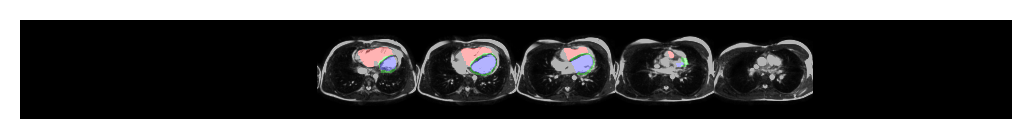

2020-12-01 18:01:44,948 INFO GT on AX


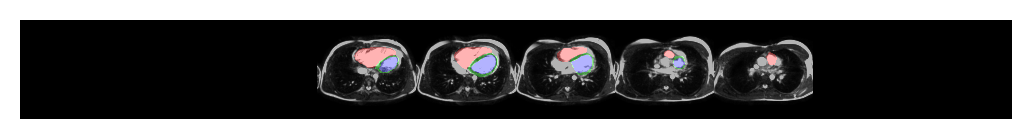

2020-12-01 18:01:45,407 INFO inv mask shape: (20, 256, 256, 4), gt mask shape: (20, 256, 256, 4)
2020-12-01 18:01:45,415 INFO DICE LV: 0.920049250125885
2020-12-01 18:01:45,422 INFO DICE RV: 0.7566438317298889
2020-12-01 18:01:45,428 INFO DICE MYO: 0.6721668243408203
2020-12-01 18:01:45,478 INFO m: [[ 0.4692 -0.8096 -0.3528 -0.999 ]
 [ 0.3418 -0.2021  0.918  -0.994 ]
 [-0.8145 -0.5513  0.182  15.234 ]]
2020-12-01 18:01:45,479 INFO m_mod: [[ 0.4692 -0.8096 -0.3528 -0.583 ]
 [ 0.3418 -0.2021  0.918  -0.542 ]
 [-0.8145 -0.5513  0.182   1.919 ]]
2020-12-01 18:01:45,479 INFO m_scaled: [[ 0.4692 -0.8096 -0.3528 -1.166 ]
 [ 0.3418 -0.2021  0.918  -1.084 ]
 [-0.8145 -0.5513  0.182   3.838 ]]
2020-12-01 18:01:45,480 INFO 0000-1E4PF7MR_2006-07-06_ES_msk.nrrd
2020-12-01 18:01:50,405 INFO DICE LV: 0.894076406955719
2020-12-01 18:01:50,489 INFO DICE RV: 0.7235063314437866
2020-12-01 18:01:50,567 INFO DICE MYO: 0.7342880368232727
2020-12-01 18:01:51,077 INFO Predicted mask rotated to AX on original 

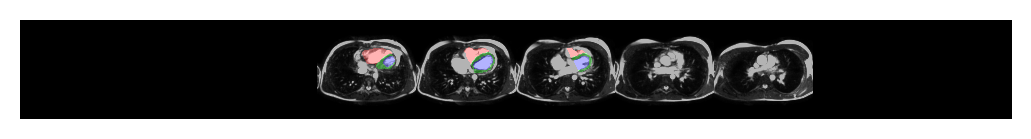

2020-12-01 18:01:51,466 INFO GT on AX


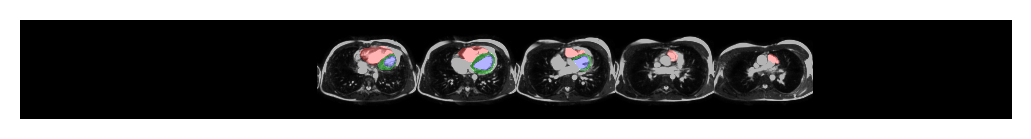

2020-12-01 18:01:51,940 INFO inv mask shape: (20, 256, 256, 4), gt mask shape: (20, 256, 256, 4)
2020-12-01 18:01:51,948 INFO DICE LV: 0.9097869992256165
2020-12-01 18:01:51,955 INFO DICE RV: 0.7351691126823425
2020-12-01 18:01:51,962 INFO DICE MYO: 0.7479158043861389
2020-12-01 18:01:52,020 INFO m: [[ 0.4695 -0.8105 -0.3513 -0.999 ]
 [ 0.3418 -0.2001  0.919  -0.994 ]
 [-0.8145 -0.5513  0.1831 15.21  ]]
2020-12-01 18:01:52,021 INFO m_mod: [[ 0.4695 -0.8105 -0.3513 -0.582 ]
 [ 0.3418 -0.2001  0.919  -0.5415]
 [-0.8145 -0.5513  0.1831  1.916 ]]
2020-12-01 18:01:52,021 INFO m_scaled: [[ 0.4695 -0.8105 -0.3513 -1.164 ]
 [ 0.3418 -0.2001  0.919  -1.083 ]
 [-0.8145 -0.5513  0.1831  3.832 ]]
2020-12-01 18:01:52,022 INFO 0000-2FUH59VD_2006-08-24_ED_msk.nrrd
2020-12-01 18:01:56,852 INFO DICE LV: 0.9114277958869934
2020-12-01 18:01:56,935 INFO DICE RV: 0.8488844633102417
2020-12-01 18:01:57,023 INFO DICE MYO: 0.7012929916381836
2020-12-01 18:01:57,523 INFO Predicted mask rotated to AX on origina

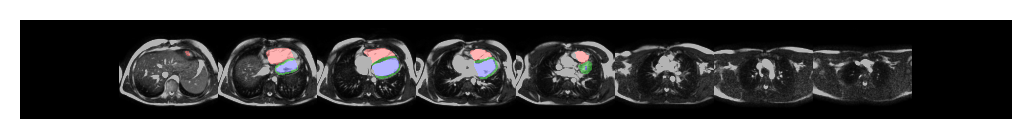

2020-12-01 18:01:57,923 INFO GT on AX


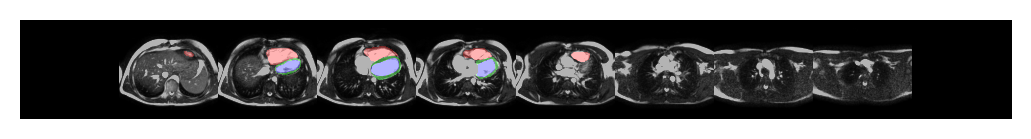

2020-12-01 18:01:58,529 INFO inv mask shape: (32, 256, 256, 4), gt mask shape: (32, 256, 256, 4)
2020-12-01 18:01:58,538 INFO DICE LV: 0.9131743311882019
2020-12-01 18:01:58,546 INFO DICE RV: 0.8529039025306702
2020-12-01 18:01:58,555 INFO DICE MYO: 0.7075274586677551
2020-12-01 18:01:58,614 INFO m: [[ 0.4685 -0.8086 -0.3562 -0.999 ]
 [ 0.342  -0.2058  0.917  -0.994 ]
 [-0.8145 -0.5513  0.1803 15.28  ]]
2020-12-01 18:01:58,615 INFO m_mod: [[ 0.4685 -0.8086 -0.3562 -0.584 ]
 [ 0.342  -0.2058  0.917  -0.543 ]
 [-0.8145 -0.5513  0.1803  1.926 ]]
2020-12-01 18:01:58,615 INFO m_scaled: [[ 0.4685 -0.8086 -0.3562 -1.168 ]
 [ 0.342  -0.2058  0.917  -1.086 ]
 [-0.8145 -0.5513  0.1803  3.852 ]]
2020-12-01 18:01:58,616 INFO 0000-2FUH59VD_2006-08-24_ES_msk.nrrd
2020-12-01 18:02:03,558 INFO DICE LV: 0.7793833017349243
2020-12-01 18:02:03,650 INFO DICE RV: 0.7772830724716187
2020-12-01 18:02:03,737 INFO DICE MYO: 0.7311690449714661
2020-12-01 18:02:04,244 INFO Predicted mask rotated to AX on origina

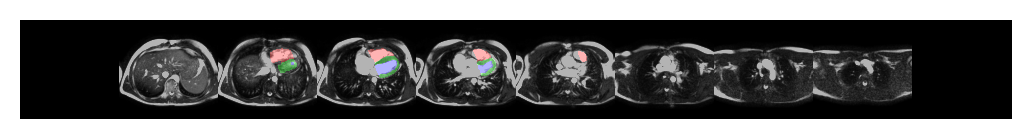

2020-12-01 18:02:04,647 INFO GT on AX


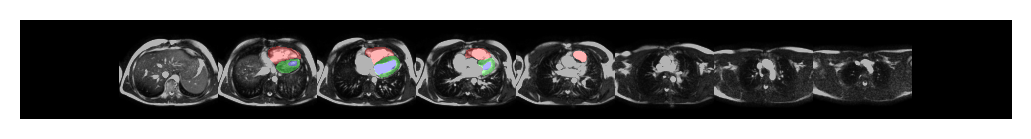

2020-12-01 18:02:05,264 INFO inv mask shape: (32, 256, 256, 4), gt mask shape: (32, 256, 256, 4)
2020-12-01 18:02:05,273 INFO DICE LV: 0.7744829654693604
2020-12-01 18:02:05,284 INFO DICE RV: 0.7762426137924194
2020-12-01 18:02:05,293 INFO DICE MYO: 0.7198266386985779
2020-12-01 18:02:05,353 INFO m: [[ 0.4673 -0.8066 -0.3618 -0.999 ]
 [ 0.3428 -0.212   0.915  -0.994 ]
 [-0.815  -0.552   0.1775 15.34  ]]
2020-12-01 18:02:05,354 INFO m_mod: [[ 0.4673 -0.8066 -0.3618 -0.5854]
 [ 0.3428 -0.212   0.915  -0.5444]
 [-0.815  -0.552   0.1775  1.933 ]]
2020-12-01 18:02:05,354 INFO m_scaled: [[ 0.4673 -0.8066 -0.3618 -1.171 ]
 [ 0.3428 -0.212   0.915  -1.089 ]
 [-0.815  -0.552   0.1775  3.865 ]]
2020-12-01 18:02:05,355 INFO 0000-2VRMJ3ZF_2006-01-17_ED_msk.nrrd
2020-12-01 18:02:10,242 INFO DICE LV: 0.8922829627990723
2020-12-01 18:02:10,323 INFO DICE RV: 0.8393629193305969
2020-12-01 18:02:10,402 INFO DICE MYO: 0.5814274549484253
2020-12-01 18:02:10,945 INFO Predicted mask rotated to AX on origina

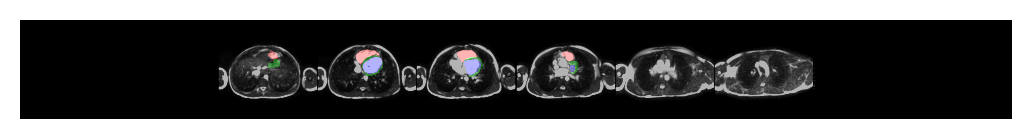

2020-12-01 18:02:11,338 INFO GT on AX


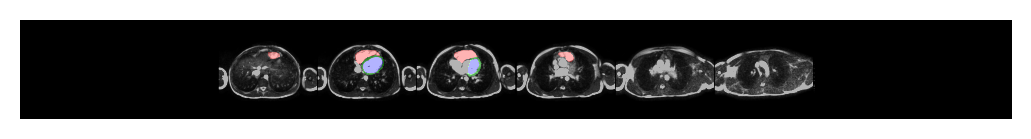

2020-12-01 18:02:11,859 INFO inv mask shape: (26, 256, 256, 4), gt mask shape: (26, 256, 256, 4)
2020-12-01 18:02:11,866 INFO DICE LV: 0.8948855996131897
2020-12-01 18:02:11,873 INFO DICE RV: 0.8515667915344238
2020-12-01 18:02:11,879 INFO DICE MYO: 0.6090402603149414
2020-12-01 18:02:11,937 INFO m: [[ 0.4692 -0.8096 -0.3528 -0.999 ]
 [ 0.3418 -0.2021  0.918  -0.994 ]
 [-0.8145 -0.5513  0.182  15.21  ]]
2020-12-01 18:02:11,937 INFO m_mod: [[ 0.4692 -0.8096 -0.3528 -0.582 ]
 [ 0.3418 -0.2021  0.918  -0.542 ]
 [-0.8145 -0.5513  0.182   1.916 ]]
2020-12-01 18:02:11,938 INFO m_scaled: [[ 0.4692 -0.8096 -0.3528 -1.164 ]
 [ 0.3418 -0.2021  0.918  -1.084 ]
 [-0.8145 -0.5513  0.182   3.832 ]]
2020-12-01 18:02:11,939 INFO 0000-2VRMJ3ZF_2006-01-17_ES_msk.nrrd
2020-12-01 18:02:16,843 INFO DICE LV: 0.8493651747703552
2020-12-01 18:02:16,932 INFO DICE RV: 0.7883700132369995
2020-12-01 18:02:17,014 INFO DICE MYO: 0.6962660551071167
2020-12-01 18:02:17,526 INFO Predicted mask rotated to AX on origina

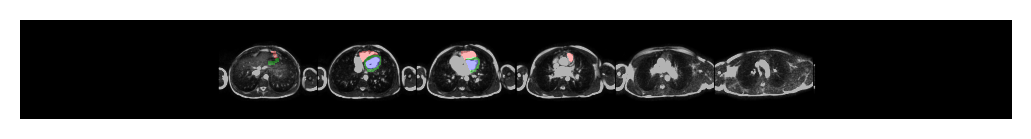

2020-12-01 18:02:17,939 INFO GT on AX


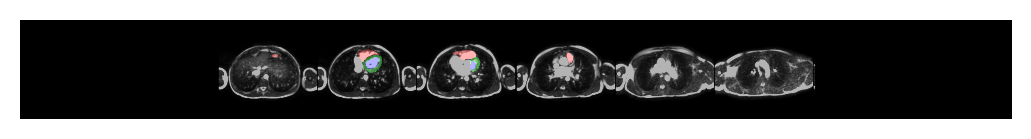

2020-12-01 18:02:18,473 INFO inv mask shape: (26, 256, 256, 4), gt mask shape: (26, 256, 256, 4)
2020-12-01 18:02:18,480 INFO DICE LV: 0.8625681400299072
2020-12-01 18:02:18,486 INFO DICE RV: 0.8073995113372803
2020-12-01 18:02:18,493 INFO DICE MYO: 0.6938759684562683
2020-12-01 18:02:18,554 INFO m: [[ 0.4717 -0.814  -0.3394 -0.999 ]
 [ 0.341  -0.1868  0.9214 -0.9937]
 [-0.8135 -0.5503  0.1895 15.055 ]]
2020-12-01 18:02:18,555 INFO m_mod: [[ 0.4717 -0.814  -0.3394 -0.578 ]
 [ 0.341  -0.1868  0.9214 -0.538 ]
 [-0.8135 -0.5503  0.1895  1.8955]]
2020-12-01 18:02:18,556 INFO m_scaled: [[ 0.4717 -0.814  -0.3394 -1.156 ]
 [ 0.341  -0.1868  0.9214 -1.076 ]
 [-0.8135 -0.5503  0.1895  3.791 ]]
2020-12-01 18:02:18,558 INFO 0000-2Y9U5LLC_2006-07-24_ED_msk.nrrd
2020-12-01 18:02:24,491 INFO DICE LV: 0.9017755389213562
2020-12-01 18:02:24,585 INFO DICE RV: 0.8287957906723022
2020-12-01 18:02:24,674 INFO DICE MYO: 0.6021566987037659
2020-12-01 18:02:25,179 INFO Predicted mask rotated to AX on origina

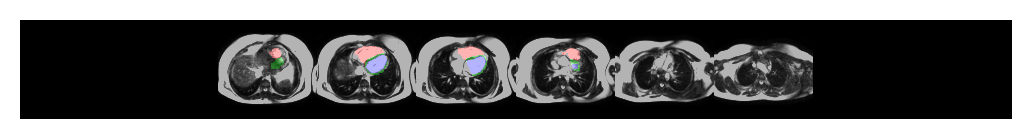

2020-12-01 18:02:25,572 INFO GT on AX


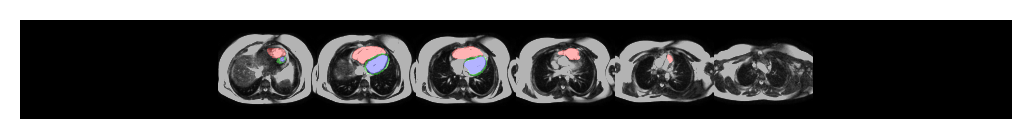

2020-12-01 18:02:26,090 INFO inv mask shape: (24, 256, 256, 4), gt mask shape: (24, 256, 256, 4)
2020-12-01 18:02:26,098 INFO DICE LV: 0.9062166213989258
2020-12-01 18:02:26,105 INFO DICE RV: 0.8311530351638794
2020-12-01 18:02:26,114 INFO DICE MYO: 0.6221026182174683
2020-12-01 18:02:26,170 INFO m: [[ 0.483  -0.833  -0.2717 -0.9985]
 [ 0.3354 -0.111   0.9355 -0.992 ]
 [-0.809  -0.543   0.2258 14.34  ]]
2020-12-01 18:02:26,170 INFO m_mod: [[ 0.483  -0.833  -0.2717 -0.561 ]
 [ 0.3354 -0.111   0.9355 -0.5205]
 [-0.809  -0.543   0.2258  1.808 ]]
2020-12-01 18:02:26,171 INFO m_scaled: [[ 0.483  -0.833  -0.2717 -1.122 ]
 [ 0.3354 -0.111   0.9355 -1.041 ]
 [-0.809  -0.543   0.2258  3.615 ]]
2020-12-01 18:02:26,172 INFO 0000-2Y9U5LLC_2006-07-24_ES_msk.nrrd
2020-12-01 18:02:30,934 INFO DICE LV: 0.8267518877983093
2020-12-01 18:02:31,019 INFO DICE RV: 0.802655816078186
2020-12-01 18:02:31,101 INFO DICE MYO: 0.7084398865699768
2020-12-01 18:02:31,604 INFO Predicted mask rotated to AX on original

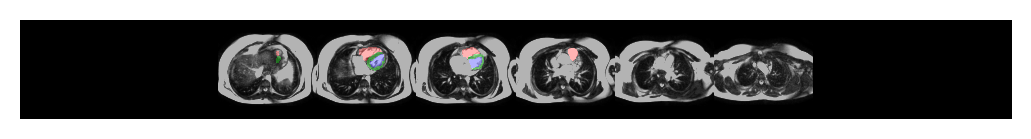

2020-12-01 18:02:31,998 INFO GT on AX


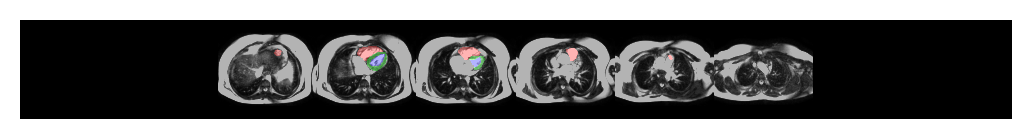

2020-12-01 18:02:32,504 INFO inv mask shape: (24, 256, 256, 4), gt mask shape: (24, 256, 256, 4)
2020-12-01 18:02:32,512 INFO DICE LV: 0.8376861810684204
2020-12-01 18:02:32,520 INFO DICE RV: 0.8040551543235779
2020-12-01 18:02:32,527 INFO DICE MYO: 0.7144467830657959
2020-12-01 18:02:32,583 INFO m: [[ 0.4841  -0.8345  -0.265   -0.9985 ]
 [ 0.3352  -0.10315  0.937   -0.9917 ]
 [-0.8086  -0.5425   0.2297  14.25   ]]
2020-12-01 18:02:32,583 INFO m_mod: [[ 0.4841  -0.8345  -0.265   -0.5586 ]
 [ 0.3352  -0.10315  0.937   -0.5186 ]
 [-0.8086  -0.5425   0.2297   1.795  ]]
2020-12-01 18:02:32,584 INFO m_scaled: [[ 0.4841  -0.8345  -0.265   -1.117  ]
 [ 0.3352  -0.10315  0.937   -1.037  ]
 [-0.8086  -0.5425   0.2297   3.59   ]]
2020-12-01 18:02:32,585 INFO 0000-3HYXWJWW_2006-11-17_ED_msk.nrrd
2020-12-01 18:02:38,342 INFO DICE LV: 0.9041357636451721
2020-12-01 18:02:38,429 INFO DICE RV: 0.7465638518333435
2020-12-01 18:02:38,514 INFO DICE MYO: 0.7055307626724243
2020-12-01 18:02:39,025 INFO Pre

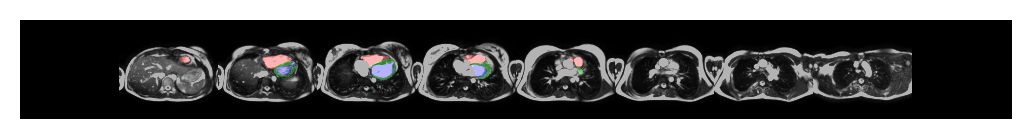

2020-12-01 18:02:39,417 INFO GT on AX


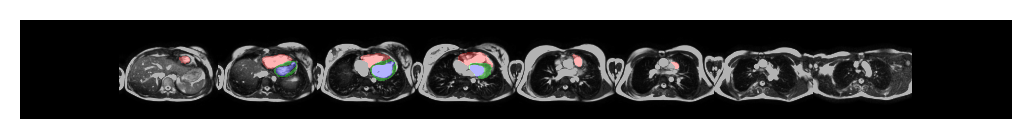

2020-12-01 18:02:40,004 INFO inv mask shape: (32, 256, 256, 4), gt mask shape: (32, 256, 256, 4)
2020-12-01 18:02:40,013 INFO DICE LV: 0.9179925918579102
2020-12-01 18:02:40,022 INFO DICE RV: 0.7476072311401367
2020-12-01 18:02:40,030 INFO DICE MYO: 0.7303537726402283
2020-12-01 18:02:40,087 INFO m: [[ 0.4695 -0.811  -0.349  -0.999 ]
 [ 0.3416 -0.1981  0.919  -0.994 ]
 [-0.8145 -0.5503  0.1841 15.2   ]]
2020-12-01 18:02:40,088 INFO m_mod: [[ 0.4695 -0.811  -0.349  -0.582 ]
 [ 0.3416 -0.1981  0.919  -0.541 ]
 [-0.8145 -0.5503  0.1841  1.916 ]]
2020-12-01 18:02:40,088 INFO m_scaled: [[ 0.4695 -0.811  -0.349  -1.164 ]
 [ 0.3416 -0.1981  0.919  -1.082 ]
 [-0.8145 -0.5503  0.1841  3.832 ]]
2020-12-01 18:02:40,090 INFO 0000-3HYXWJWW_2006-11-17_ES_msk.nrrd
2020-12-01 18:02:44,872 INFO DICE LV: 0.8302451372146606
2020-12-01 18:02:44,955 INFO DICE RV: 0.6650679707527161
2020-12-01 18:02:45,036 INFO DICE MYO: 0.7368778586387634
2020-12-01 18:02:45,531 INFO Predicted mask rotated to AX on origina

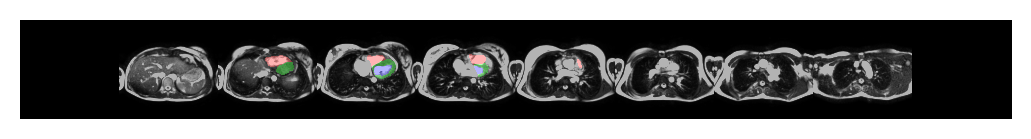

2020-12-01 18:02:45,930 INFO GT on AX


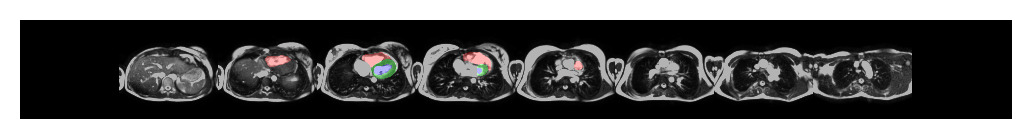

2020-12-01 18:02:46,525 INFO inv mask shape: (32, 256, 256, 4), gt mask shape: (32, 256, 256, 4)
2020-12-01 18:02:46,534 INFO DICE LV: 0.8331915140151978
2020-12-01 18:02:46,543 INFO DICE RV: 0.6585301160812378
2020-12-01 18:02:46,552 INFO DICE MYO: 0.7491264343261719
2020-12-01 18:02:46,612 INFO m: [[ 0.4697 -0.812  -0.347  -0.999 ]
 [ 0.3413 -0.1954  0.9194 -0.994 ]
 [-0.814  -0.5503  0.1853 15.17  ]]
2020-12-01 18:02:46,613 INFO m_mod: [[ 0.4697 -0.812  -0.347  -0.581 ]
 [ 0.3413 -0.1954  0.9194 -0.5405]
 [-0.814  -0.5503  0.1853  1.912 ]]
2020-12-01 18:02:46,613 INFO m_scaled: [[ 0.4697 -0.812  -0.347  -1.162 ]
 [ 0.3413 -0.1954  0.9194 -1.081 ]
 [-0.814  -0.5503  0.1853  3.824 ]]
2020-12-01 18:02:46,617 INFO 0000-3U3KT9LV_2006-12-19_ED_msk.nrrd
2020-12-01 18:02:52,409 INFO DICE LV: 0.929756760597229
2020-12-01 18:02:52,498 INFO DICE RV: 0.7458941340446472
2020-12-01 18:02:52,592 INFO DICE MYO: 0.715204119682312
2020-12-01 18:02:53,090 INFO Predicted mask rotated to AX on original 

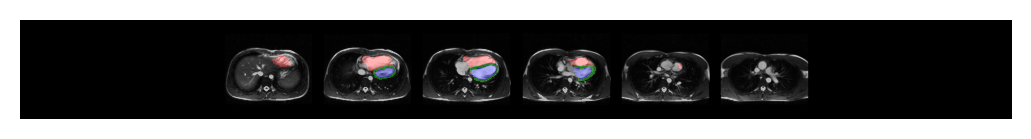

2020-12-01 18:02:53,484 INFO GT on AX


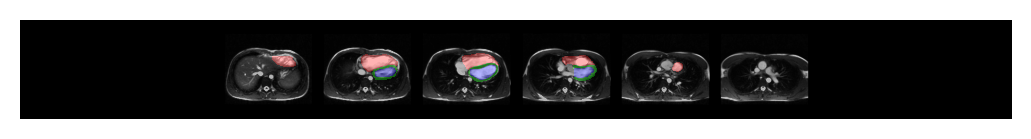

2020-12-01 18:02:53,914 INFO inv mask shape: (25, 156, 192, 4), gt mask shape: (25, 156, 192, 4)
2020-12-01 18:02:53,919 INFO DICE LV: 0.9368800520896912
2020-12-01 18:02:53,924 INFO DICE RV: 0.7474263906478882
2020-12-01 18:02:53,928 INFO DICE MYO: 0.7153661847114563
2020-12-01 18:02:53,982 INFO m: [[ 0.4614 -0.7925 -0.4    -0.9995]
 [ 0.3452 -0.255   0.9033 -0.995 ]
 [-0.8174 -0.5547  0.1559 15.76  ]]
2020-12-01 18:02:53,982 INFO m_mod: [[ 0.4614 -0.7925 -0.4    -0.595 ]
 [ 0.3452 -0.255   0.9033 -0.554 ]
 [-0.8174 -0.5547  0.1559  1.984 ]]
2020-12-01 18:02:53,983 INFO m_scaled: [[ 0.4614 -0.7925 -0.4    -1.19  ]
 [ 0.3452 -0.255   0.9033 -1.108 ]
 [-0.8174 -0.5547  0.1559  3.969 ]]
2020-12-01 18:02:53,984 INFO 0000-3U3KT9LV_2006-12-19_ES_msk.nrrd
2020-12-01 18:02:58,721 INFO DICE LV: 0.8509886264801025
2020-12-01 18:02:58,810 INFO DICE RV: 0.6882713437080383
2020-12-01 18:02:58,897 INFO DICE MYO: 0.7109107971191406
2020-12-01 18:02:59,396 INFO Predicted mask rotated to AX on origina

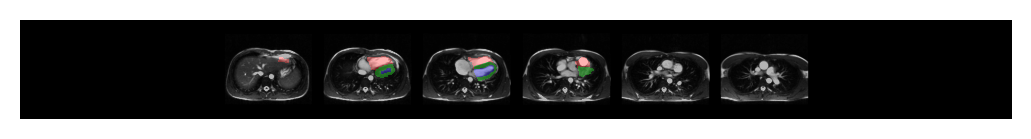

2020-12-01 18:02:59,787 INFO GT on AX


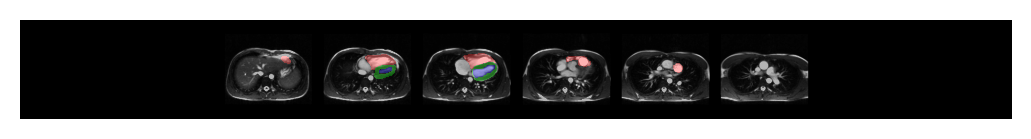

2020-12-01 18:03:00,201 INFO inv mask shape: (25, 156, 192, 4), gt mask shape: (25, 156, 192, 4)
2020-12-01 18:03:00,206 INFO DICE LV: 0.8466536998748779
2020-12-01 18:03:00,210 INFO DICE RV: 0.6858535408973694
2020-12-01 18:03:00,214 INFO DICE MYO: 0.7139173150062561
2020-12-01 18:03:00,271 INFO m: [[ 0.4614 -0.7925 -0.4    -0.9995]
 [ 0.3452 -0.255   0.9033 -0.995 ]
 [-0.8174 -0.5547  0.1559 15.766 ]]
2020-12-01 18:03:00,271 INFO m_mod: [[ 0.4614 -0.7925 -0.4    -0.5957]
 [ 0.3452 -0.255   0.9033 -0.5547]
 [-0.8174 -0.5547  0.1559  1.985 ]]
2020-12-01 18:03:00,272 INFO m_scaled: [[ 0.4614 -0.7925 -0.4    -1.191 ]
 [ 0.3452 -0.255   0.9033 -1.109 ]
 [-0.8174 -0.5547  0.1559  3.97  ]]
2020-12-01 18:03:00,273 INFO 0000-4A4PVCYL_2006-09-01_ED_msk.nrrd
2020-12-01 18:03:05,038 INFO DICE LV: 0.2821899354457855
2020-12-01 18:03:05,120 INFO DICE RV: 0.2817244827747345
2020-12-01 18:03:05,201 INFO DICE MYO: 0.1684274524450302
2020-12-01 18:03:05,777 INFO Predicted mask rotated to AX on origina

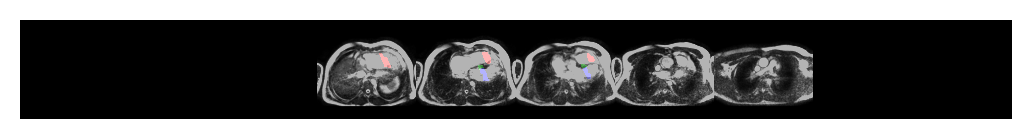

2020-12-01 18:03:06,167 INFO GT on AX


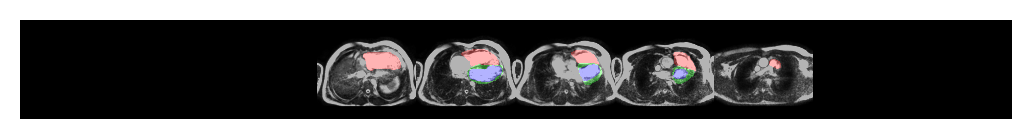

2020-12-01 18:03:06,668 INFO inv mask shape: (20, 256, 256, 4), gt mask shape: (20, 256, 256, 4)
2020-12-01 18:03:06,675 INFO DICE LV: 0.2570417821407318
2020-12-01 18:03:06,681 INFO DICE RV: 0.21091531217098236
2020-12-01 18:03:06,688 INFO DICE MYO: 0.13148421049118042
2020-12-01 18:03:06,747 INFO m: [[ 0.4634 -0.797  -0.387  -0.9995]
 [ 0.3445 -0.2401  0.9077 -0.9946]
 [-0.8164 -0.5537  0.1632 15.65  ]]
2020-12-01 18:03:06,748 INFO m_mod: [[ 0.4634 -0.797  -0.387  -0.593 ]
 [ 0.3445 -0.2401  0.9077 -0.552 ]
 [-0.8164 -0.5537  0.1632  1.971 ]]
2020-12-01 18:03:06,748 INFO m_scaled: [[ 0.4634 -0.797  -0.387  -1.186 ]
 [ 0.3445 -0.2401  0.9077 -1.104 ]
 [-0.8164 -0.5537  0.1632  3.941 ]]
2020-12-01 18:03:06,749 INFO 0000-4A4PVCYL_2006-09-01_ES_msk.nrrd
2020-12-01 18:03:11,482 INFO DICE LV: 0.1682865023612976
2020-12-01 18:03:11,571 INFO DICE RV: 0.3457210659980774
2020-12-01 18:03:11,651 INFO DICE MYO: 0.10247182101011276
2020-12-01 18:03:12,145 INFO Predicted mask rotated to AX on orig

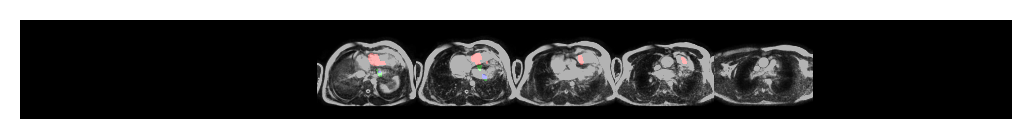

2020-12-01 18:03:12,541 INFO GT on AX


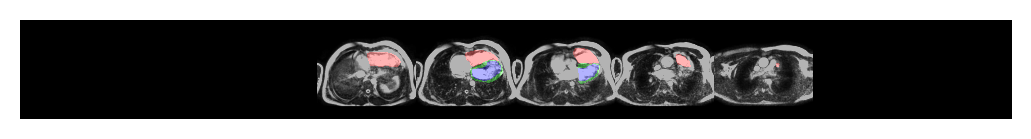

2020-12-01 18:03:13,034 INFO inv mask shape: (20, 256, 256, 4), gt mask shape: (20, 256, 256, 4)
2020-12-01 18:03:13,039 INFO DICE LV: 0.13544848561286926
2020-12-01 18:03:13,045 INFO DICE RV: 0.36059218645095825
2020-12-01 18:03:13,050 INFO DICE MYO: 0.082508884370327
2020-12-01 18:03:13,108 INFO m: [[ 0.4624 -0.796  -0.3914 -0.9995]
 [ 0.3447 -0.2452  0.9062 -0.995 ]
 [-0.817  -0.5537  0.1609 15.68  ]]
2020-12-01 18:03:13,109 INFO m_mod: [[ 0.4624 -0.796  -0.3914 -0.5938]
 [ 0.3447 -0.2452  0.9062 -0.5522]
 [-0.817  -0.5537  0.1609  1.976 ]]
2020-12-01 18:03:13,109 INFO m_scaled: [[ 0.4624 -0.796  -0.3914 -1.1875]
 [ 0.3447 -0.2452  0.9062 -1.1045]
 [-0.817  -0.5537  0.1609  3.951 ]]
2020-12-01 18:03:13,110 INFO 0000-5RRMWQX2_2005-06-10_ED_msk.nrrd
2020-12-01 18:03:19,884 INFO DICE LV: 0.8371137976646423
2020-12-01 18:03:19,971 INFO DICE RV: 0.7799631953239441
2020-12-01 18:03:20,052 INFO DICE MYO: 0.5817200541496277
2020-12-01 18:03:20,544 INFO Predicted mask rotated to AX on origin

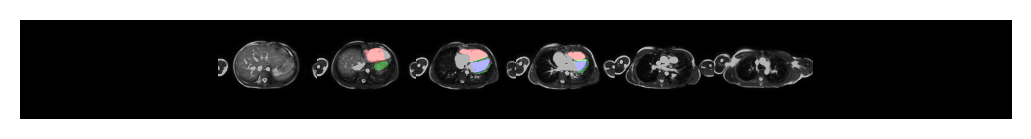

2020-12-01 18:03:20,931 INFO GT on AX


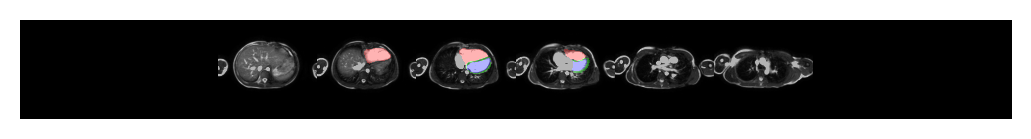

2020-12-01 18:03:21,423 INFO inv mask shape: (16, 256, 256, 4), gt mask shape: (16, 256, 256, 4)
2020-12-01 18:03:21,429 INFO DICE LV: 0.8381075859069824
2020-12-01 18:03:21,434 INFO DICE RV: 0.7935764193534851
2020-12-01 18:03:21,439 INFO DICE MYO: 0.5692334771156311
2020-12-01 18:03:21,496 INFO m: [[ 0.4683 -0.8066 -0.3613 -0.999 ]
 [ 0.3428 -0.211   0.916  -0.994 ]
 [-0.8145 -0.5522  0.1776 15.31  ]]
2020-12-01 18:03:21,497 INFO m_mod: [[ 0.4683 -0.8066 -0.3613 -0.5845]
 [ 0.3428 -0.211   0.916  -0.544 ]
 [-0.8145 -0.5522  0.1776  1.928 ]]
2020-12-01 18:03:21,498 INFO m_scaled: [[ 0.4683 -0.8066 -0.3613 -1.169 ]
 [ 0.3428 -0.211   0.916  -1.088 ]
 [-0.8145 -0.5522  0.1776  3.855 ]]
2020-12-01 18:03:21,499 INFO 0000-5RRMWQX2_2005-06-10_ES_msk.nrrd
2020-12-01 18:03:26,261 INFO DICE LV: 0.7870684266090393
2020-12-01 18:03:26,349 INFO DICE RV: 0.7731294631958008
2020-12-01 18:03:26,428 INFO DICE MYO: 0.5690096020698547
2020-12-01 18:03:26,923 INFO Predicted mask rotated to AX on origina

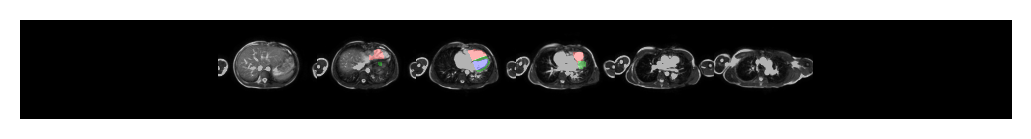

2020-12-01 18:03:27,310 INFO GT on AX


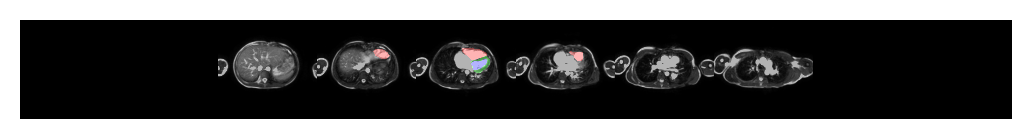

2020-12-01 18:03:27,797 INFO inv mask shape: (16, 256, 256, 4), gt mask shape: (16, 256, 256, 4)
2020-12-01 18:03:27,803 INFO DICE LV: 0.8158036470413208
2020-12-01 18:03:27,808 INFO DICE RV: 0.7918349504470825
2020-12-01 18:03:27,813 INFO DICE MYO: 0.5666428804397583
2020-12-01 18:03:27,869 INFO m: [[ 0.4685 -0.808  -0.358  -0.999 ]
 [ 0.342  -0.2076  0.9165 -0.994 ]
 [-0.8145 -0.552   0.1792 15.27  ]]
2020-12-01 18:03:27,869 INFO m_mod: [[ 0.4685 -0.808  -0.358  -0.584 ]
 [ 0.342  -0.2076  0.9165 -0.543 ]
 [-0.8145 -0.552   0.1792  1.924 ]]
2020-12-01 18:03:27,870 INFO m_scaled: [[ 0.4685 -0.808  -0.358  -1.168 ]
 [ 0.342  -0.2076  0.9165 -1.086 ]
 [-0.8145 -0.552   0.1792  3.848 ]]
2020-12-01 18:03:27,871 INFO 0000-6E5FAVTH_2007-03-28_ED_msk.nrrd
2020-12-01 18:03:32,630 INFO DICE LV: 0.7429915070533752
2020-12-01 18:03:32,711 INFO DICE RV: 0.4781333804130554
2020-12-01 18:03:32,795 INFO DICE MYO: 0.38796404004096985
2020-12-01 18:03:33,309 INFO Predicted mask rotated to AX on origin

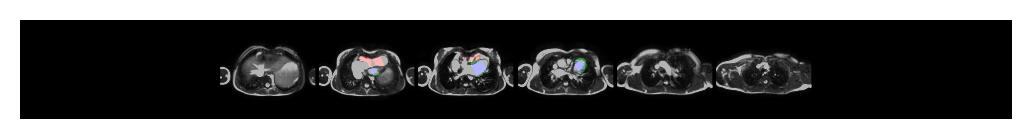

2020-12-01 18:03:33,702 INFO GT on AX


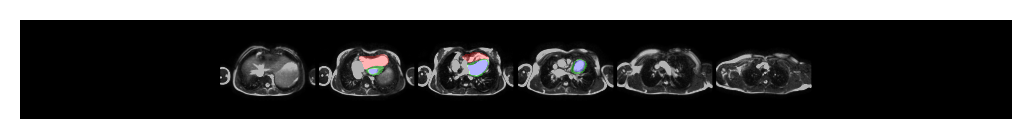

2020-12-01 18:03:34,197 INFO inv mask shape: (22, 256, 256, 4), gt mask shape: (22, 256, 256, 4)
2020-12-01 18:03:34,204 INFO DICE LV: 0.7530487775802612
2020-12-01 18:03:34,211 INFO DICE RV: 0.5443816184997559
2020-12-01 18:03:34,218 INFO DICE MYO: 0.4024055004119873
2020-12-01 18:03:34,276 INFO m: [[ 0.4685 -0.808  -0.357  -0.999 ]
 [ 0.342  -0.2065  0.9165 -0.994 ]
 [-0.8145 -0.5513  0.1797 15.266 ]]
2020-12-01 18:03:34,277 INFO m_mod: [[ 0.4685 -0.808  -0.357  -0.5835]
 [ 0.342  -0.2065  0.9165 -0.543 ]
 [-0.8145 -0.5513  0.1797  1.923 ]]
2020-12-01 18:03:34,277 INFO m_scaled: [[ 0.4685 -0.808  -0.357  -1.167 ]
 [ 0.342  -0.2065  0.9165 -1.086 ]
 [-0.8145 -0.5513  0.1797  3.846 ]]
2020-12-01 18:03:34,278 INFO 0000-6E5FAVTH_2007-03-28_ES_msk.nrrd
2020-12-01 18:03:39,013 INFO DICE LV: 0.740367591381073
2020-12-01 18:03:39,097 INFO DICE RV: 0.35227569937705994
2020-12-01 18:03:39,176 INFO DICE MYO: 0.49206089973449707
2020-12-01 18:03:39,680 INFO Predicted mask rotated to AX on origin

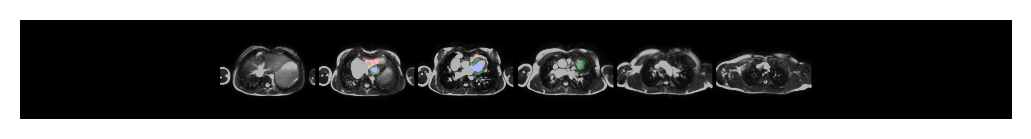

2020-12-01 18:03:40,068 INFO GT on AX


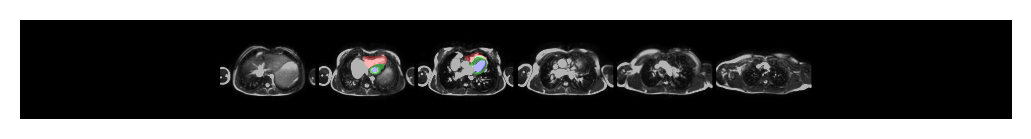

2020-12-01 18:03:40,558 INFO inv mask shape: (22, 256, 256, 4), gt mask shape: (22, 256, 256, 4)
2020-12-01 18:03:40,565 INFO DICE LV: 0.8266246914863586
2020-12-01 18:03:40,572 INFO DICE RV: 0.3757542073726654
2020-12-01 18:03:40,579 INFO DICE MYO: 0.5692469477653503
2020-12-01 18:03:40,636 INFO m: [[ 0.4695 -0.811  -0.3494 -0.999 ]
 [ 0.3416 -0.1978  0.9185 -0.994 ]
 [-0.814  -0.5503  0.1841 15.17  ]]
2020-12-01 18:03:40,637 INFO m_mod: [[ 0.4695 -0.811  -0.3494 -0.581 ]
 [ 0.3416 -0.1978  0.9185 -0.5405]
 [-0.814  -0.5503  0.1841  1.911 ]]
2020-12-01 18:03:40,638 INFO m_scaled: [[ 0.4695 -0.811  -0.3494 -1.162 ]
 [ 0.3416 -0.1978  0.9185 -1.081 ]
 [-0.814  -0.5503  0.1841  3.822 ]]
2020-12-01 18:03:40,639 INFO 0000-73FTW74F_2006-11-28_ED_msk.nrrd
2020-12-01 18:03:46,428 INFO DICE LV: 0.9185164570808411
2020-12-01 18:03:46,510 INFO DICE RV: 0.8553597927093506
2020-12-01 18:03:46,589 INFO DICE MYO: 0.6367031335830688
2020-12-01 18:03:47,091 INFO Predicted mask rotated to AX on origina

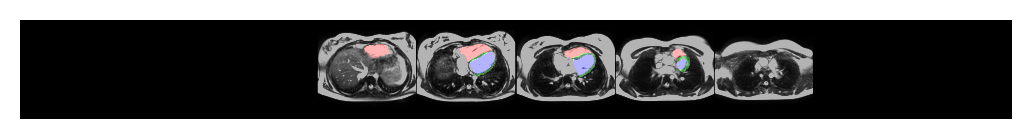

2020-12-01 18:03:47,479 INFO GT on AX


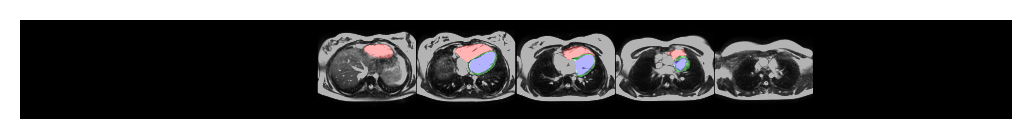

2020-12-01 18:03:50,526 INFO inv mask shape: (20, 288, 288, 4), gt mask shape: (20, 288, 288, 4)
2020-12-01 18:03:50,535 INFO DICE LV: 0.9303662776947021
2020-12-01 18:03:50,545 INFO DICE RV: 0.871131420135498
2020-12-01 18:03:50,554 INFO DICE MYO: 0.6496626734733582
2020-12-01 18:03:50,595 INFO m: [[ 0.478  -0.8257 -0.299  -0.999 ]
 [ 0.338  -0.1412  0.9307 -0.9927]
 [-0.8105 -0.546   0.2115 14.63  ]]
2020-12-01 18:03:50,596 INFO m_mod: [[ 0.478  -0.8257 -0.299  -0.5684]
 [ 0.338  -0.1412  0.9307 -0.5273]
 [-0.8105 -0.546   0.2115  1.844 ]]
2020-12-01 18:03:50,597 INFO m_scaled: [[ 0.478  -0.8257 -0.299  -1.137 ]
 [ 0.338  -0.1412  0.9307 -1.055 ]
 [-0.8105 -0.546   0.2115  3.688 ]]
2020-12-01 18:03:50,598 INFO 0000-73FTW74F_2006-11-28_ES_msk.nrrd
2020-12-01 18:03:55,658 INFO DICE LV: 0.8714034557342529
2020-12-01 18:03:55,726 INFO DICE RV: 0.7841957807540894
2020-12-01 18:03:55,791 INFO DICE MYO: 0.6755236983299255
2020-12-01 18:03:56,280 INFO Predicted mask rotated to AX on original

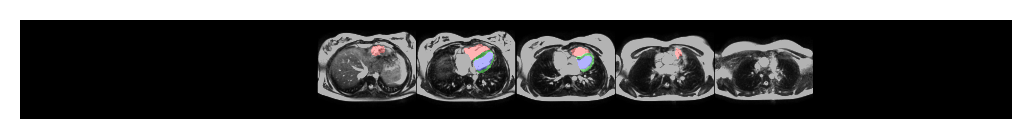

2020-12-01 18:03:56,680 INFO GT on AX


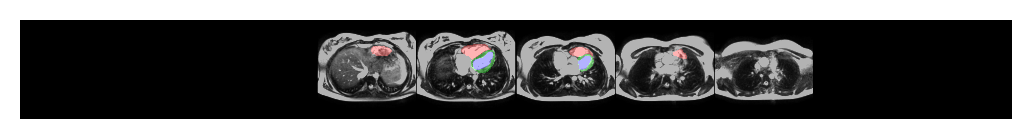

2020-12-01 18:03:57,137 INFO inv mask shape: (20, 288, 288, 4), gt mask shape: (20, 288, 288, 4)
2020-12-01 18:03:57,145 INFO DICE LV: 0.8631836771965027
2020-12-01 18:03:57,151 INFO DICE RV: 0.8052623271942139
2020-12-01 18:03:57,159 INFO DICE MYO: 0.6699230074882507
2020-12-01 18:03:57,200 INFO m: [[ 0.4797 -0.8276 -0.2905 -0.999 ]
 [ 0.3374 -0.1316  0.932  -0.9927]
 [-0.81   -0.5454  0.2162 14.55  ]]
2020-12-01 18:03:57,200 INFO m_mod: [[ 0.4797 -0.8276 -0.2905 -0.5664]
 [ 0.3374 -0.1316  0.932  -0.5254]
 [-0.81   -0.5454  0.2162  1.833 ]]
2020-12-01 18:03:57,201 INFO m_scaled: [[ 0.4797 -0.8276 -0.2905 -1.133 ]
 [ 0.3374 -0.1316  0.932  -1.051 ]
 [-0.81   -0.5454  0.2162  3.666 ]]
2020-12-01 18:03:57,202 INFO 0000-8NFJ8VMR_2006-11-10_ED_msk.nrrd
2020-12-01 18:04:02,109 INFO DICE LV: 0.9152426719665527
2020-12-01 18:04:02,179 INFO DICE RV: 0.8616848587989807
2020-12-01 18:04:02,246 INFO DICE MYO: 0.6637689471244812
2020-12-01 18:04:02,718 INFO Predicted mask rotated to AX on origina

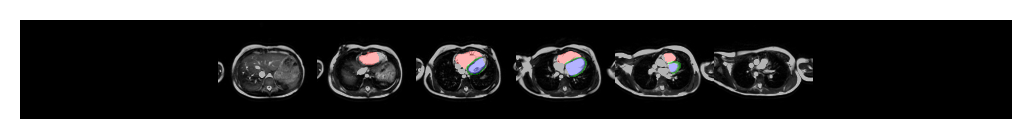

2020-12-01 18:04:03,110 INFO GT on AX


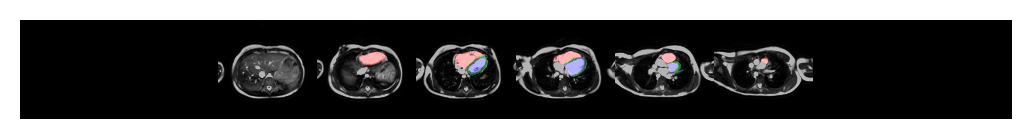

2020-12-01 18:04:03,566 INFO inv mask shape: (22, 256, 256, 4), gt mask shape: (22, 256, 256, 4)
2020-12-01 18:04:03,573 INFO DICE LV: 0.9164334535598755
2020-12-01 18:04:03,580 INFO DICE RV: 0.8763989210128784
2020-12-01 18:04:03,587 INFO DICE MYO: 0.6565637588500977
2020-12-01 18:04:03,628 INFO m: [[ 0.4797 -0.827  -0.2935 -0.999 ]
 [ 0.3376 -0.1349  0.9316 -0.9927]
 [-0.81   -0.546   0.2145 14.555 ]]
2020-12-01 18:04:03,629 INFO m_mod: [[ 0.4797 -0.827  -0.2935 -0.5664]
 [ 0.3376 -0.1349  0.9316 -0.526 ]
 [-0.81   -0.546   0.2145  1.833 ]]
2020-12-01 18:04:03,630 INFO m_scaled: [[ 0.4797 -0.827  -0.2935 -1.133 ]
 [ 0.3376 -0.1349  0.9316 -1.052 ]
 [-0.81   -0.546   0.2145  3.666 ]]
2020-12-01 18:04:03,631 INFO 0000-8NFJ8VMR_2006-11-10_ES_msk.nrrd
2020-12-01 18:04:08,412 INFO DICE LV: 0.8286258578300476
2020-12-01 18:04:08,482 INFO DICE RV: 0.7374125123023987
2020-12-01 18:04:08,548 INFO DICE MYO: 0.6794316172599792
2020-12-01 18:04:09,030 INFO Predicted mask rotated to AX on origina

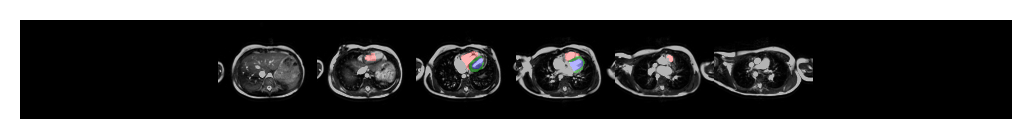

2020-12-01 18:04:09,423 INFO GT on AX


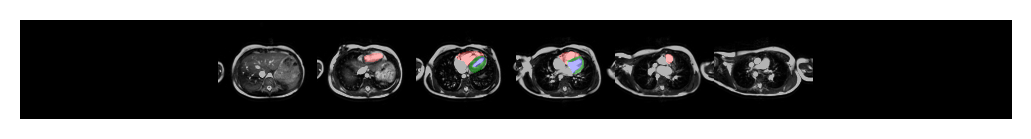

2020-12-01 18:04:09,871 INFO inv mask shape: (22, 256, 256, 4), gt mask shape: (22, 256, 256, 4)
2020-12-01 18:04:09,878 INFO DICE LV: 0.8362295031547546
2020-12-01 18:04:09,885 INFO DICE RV: 0.751478374004364
2020-12-01 18:04:09,892 INFO DICE MYO: 0.6813883781433105
2020-12-01 18:04:09,932 INFO m: [[ 0.478  -0.8247 -0.3008 -0.999 ]
 [ 0.338  -0.1432  0.9297 -0.9927]
 [-0.8105 -0.5464  0.2104 14.63  ]]
2020-12-01 18:04:09,933 INFO m_mod: [[ 0.478  -0.8247 -0.3008 -0.5684]
 [ 0.338  -0.1432  0.9297 -0.5273]
 [-0.8105 -0.5464  0.2104  1.843 ]]
2020-12-01 18:04:09,933 INFO m_scaled: [[ 0.478  -0.8247 -0.3008 -1.137 ]
 [ 0.338  -0.1432  0.9297 -1.055 ]
 [-0.8105 -0.5464  0.2104  3.686 ]]
2020-12-01 18:04:09,934 INFO 0000-8WTUG5ML_2006-07-27_ED_msk.nrrd
2020-12-01 18:04:14,680 INFO DICE LV: 0.9114042520523071
2020-12-01 18:04:14,751 INFO DICE RV: 0.8386109471321106
2020-12-01 18:04:14,817 INFO DICE MYO: 0.7064819931983948
2020-12-01 18:04:15,294 INFO Predicted mask rotated to AX on original

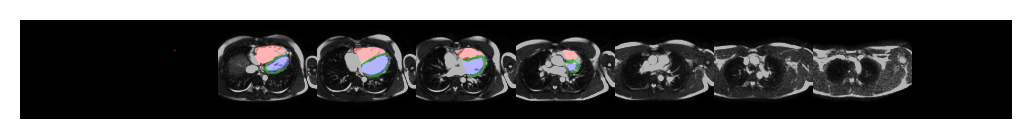

2020-12-01 18:04:15,686 INFO GT on AX


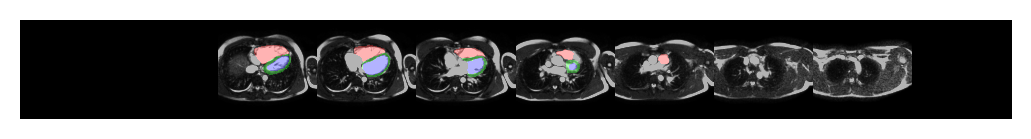

2020-12-01 18:04:16,180 INFO inv mask shape: (30, 256, 256, 4), gt mask shape: (30, 256, 256, 4)
2020-12-01 18:04:16,189 INFO DICE LV: 0.9178155660629272
2020-12-01 18:04:16,198 INFO DICE RV: 0.8463283777236938
2020-12-01 18:04:16,206 INFO DICE MYO: 0.6929289102554321
2020-12-01 18:04:16,247 INFO m: [[ 0.4685 -0.808  -0.358  -0.999 ]
 [ 0.342  -0.2076  0.9165 -0.994 ]
 [-0.8145 -0.552   0.1792 15.29  ]]
2020-12-01 18:04:16,247 INFO m_mod: [[ 0.4685 -0.808  -0.358  -0.584 ]
 [ 0.342  -0.2076  0.9165 -0.543 ]
 [-0.8145 -0.552   0.1792  1.926 ]]
2020-12-01 18:04:16,248 INFO m_scaled: [[ 0.4685 -0.808  -0.358  -1.168 ]
 [ 0.342  -0.2076  0.9165 -1.086 ]
 [-0.8145 -0.552   0.1792  3.852 ]]
2020-12-01 18:04:16,249 INFO 0000-8WTUG5ML_2006-07-27_ES_msk.nrrd
2020-12-01 18:04:20,985 INFO DICE LV: 0.8889663219451904
2020-12-01 18:04:21,057 INFO DICE RV: 0.7211188077926636
2020-12-01 18:04:21,122 INFO DICE MYO: 0.669897198677063
2020-12-01 18:04:21,596 INFO Predicted mask rotated to AX on original

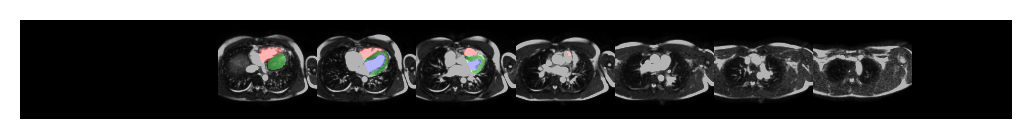

2020-12-01 18:04:22,015 INFO GT on AX


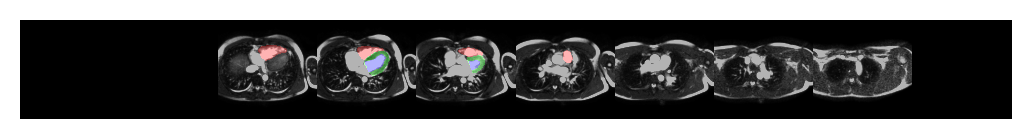

2020-12-01 18:04:22,514 INFO inv mask shape: (30, 256, 256, 4), gt mask shape: (30, 256, 256, 4)
2020-12-01 18:04:22,524 INFO DICE LV: 0.9002054929733276
2020-12-01 18:04:22,533 INFO DICE RV: 0.7239413261413574
2020-12-01 18:04:22,541 INFO DICE MYO: 0.6808620095252991
2020-12-01 18:04:22,582 INFO m: [[ 0.4692 -0.809  -0.3538 -0.999 ]
 [ 0.3418 -0.2029  0.9175 -0.994 ]
 [-0.8145 -0.5513  0.1814 15.24  ]]
2020-12-01 18:04:22,582 INFO m_mod: [[ 0.4692 -0.809  -0.3538 -0.583 ]
 [ 0.3418 -0.2029  0.9175 -0.542 ]
 [-0.8145 -0.5513  0.1814  1.92  ]]
2020-12-01 18:04:22,583 INFO m_scaled: [[ 0.4692 -0.809  -0.3538 -1.166 ]
 [ 0.3418 -0.2029  0.9175 -1.084 ]
 [-0.8145 -0.5513  0.1814  3.84  ]]
2020-12-01 18:04:22,583 INFO 0000-9HQPRPDH_2006-01-31_ED_msk.nrrd
2020-12-01 18:04:27,344 INFO DICE LV: 0.9315188527107239
2020-12-01 18:04:27,411 INFO DICE RV: 0.8226666450500488
2020-12-01 18:04:27,476 INFO DICE MYO: 0.6968308091163635
2020-12-01 18:04:27,946 INFO Predicted mask rotated to AX on origina

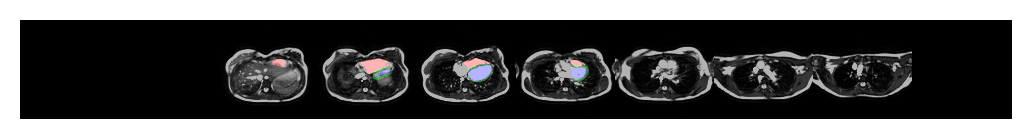

2020-12-01 18:04:28,338 INFO GT on AX


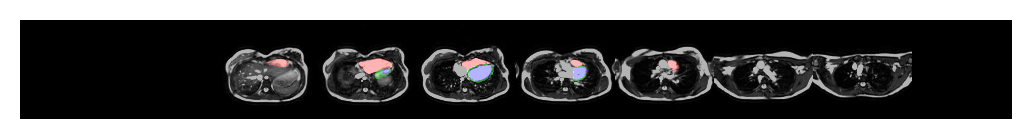

2020-12-01 18:04:28,817 INFO inv mask shape: (28, 256, 256, 4), gt mask shape: (28, 256, 256, 4)
2020-12-01 18:04:28,826 INFO DICE LV: 0.9375284910202026
2020-12-01 18:04:28,835 INFO DICE RV: 0.8216342329978943
2020-12-01 18:04:28,843 INFO DICE MYO: 0.7096172571182251
2020-12-01 18:04:28,884 INFO m: [[ 0.4736 -0.8184 -0.3247 -0.999 ]
 [ 0.3396 -0.1705  0.925  -0.993 ]
 [-0.8125 -0.5483  0.1973 14.91  ]]
2020-12-01 18:04:28,885 INFO m_mod: [[ 0.4736 -0.8184 -0.3247 -0.575 ]
 [ 0.3396 -0.1705  0.925  -0.534 ]
 [-0.8125 -0.5483  0.1973  1.878 ]]
2020-12-01 18:04:28,885 INFO m_scaled: [[ 0.4736 -0.8184 -0.3247 -1.15  ]
 [ 0.3396 -0.1705  0.925  -1.068 ]
 [-0.8125 -0.5483  0.1973  3.756 ]]
2020-12-01 18:04:28,886 INFO 0000-9HQPRPDH_2006-01-31_ES_msk.nrrd
2020-12-01 18:04:34,593 INFO DICE LV: 0.8396708369255066
2020-12-01 18:04:34,664 INFO DICE RV: 0.7441211938858032
2020-12-01 18:04:34,731 INFO DICE MYO: 0.6918838620185852
2020-12-01 18:04:35,198 INFO Predicted mask rotated to AX on origina

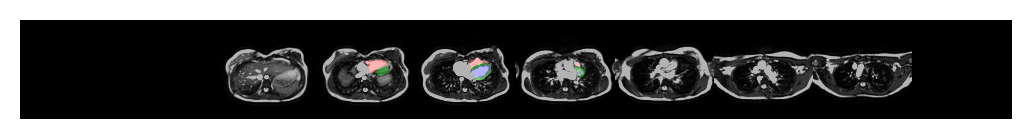

2020-12-01 18:04:35,592 INFO GT on AX


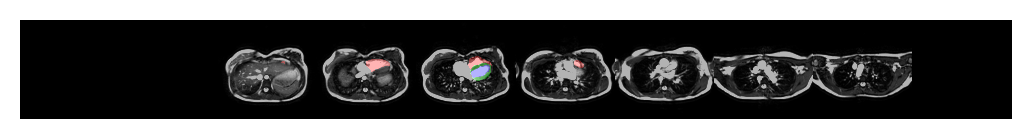

2020-12-01 18:04:36,053 INFO inv mask shape: (28, 256, 256, 4), gt mask shape: (28, 256, 256, 4)
2020-12-01 18:04:36,061 INFO DICE LV: 0.8429805040359497
2020-12-01 18:04:36,070 INFO DICE RV: 0.7515444159507751
2020-12-01 18:04:36,079 INFO DICE MYO: 0.6864416003227234
2020-12-01 18:04:36,120 INFO m: [[ 0.4756 -0.822  -0.3145 -0.999 ]
 [ 0.339  -0.1588  0.9272 -0.993 ]
 [-0.812  -0.5474  0.203  14.79  ]]
2020-12-01 18:04:36,121 INFO m_mod: [[ 0.4756 -0.822  -0.3145 -0.5723]
 [ 0.339  -0.1588  0.9272 -0.5312]
 [-0.812  -0.5474  0.203   1.863 ]]
2020-12-01 18:04:36,121 INFO m_scaled: [[ 0.4756 -0.822  -0.3145 -1.145 ]
 [ 0.339  -0.1588  0.9272 -1.0625]
 [-0.812  -0.5474  0.203   3.727 ]]
2020-12-01 18:04:36,122 INFO 0000-AEUM7ZGH_2006-09-01_ED_msk.nrrd
2020-12-01 18:04:40,808 INFO DICE LV: 0.8338339328765869
2020-12-01 18:04:40,877 INFO DICE RV: 0.7750887274742126
2020-12-01 18:04:40,944 INFO DICE MYO: 0.611558735370636
2020-12-01 18:04:41,419 INFO Predicted mask rotated to AX on original

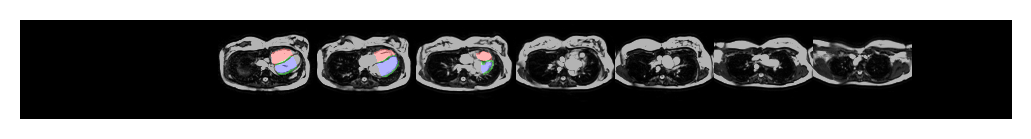

2020-12-01 18:04:41,812 INFO GT on AX


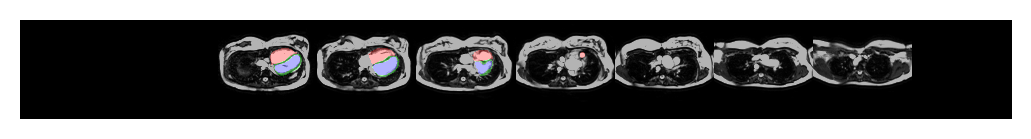

2020-12-01 18:04:42,282 INFO inv mask shape: (27, 256, 256, 4), gt mask shape: (27, 256, 256, 4)
2020-12-01 18:04:42,291 INFO DICE LV: 0.8397330045700073
2020-12-01 18:04:42,299 INFO DICE RV: 0.7719587683677673
2020-12-01 18:04:42,307 INFO DICE MYO: 0.6088008284568787
2020-12-01 18:04:42,351 INFO m: [[ 0.478  -0.825  -0.2998 -0.999 ]
 [ 0.338  -0.1421  0.9297 -0.9927]
 [-0.8105 -0.546   0.2109 14.63  ]]
2020-12-01 18:04:42,352 INFO m_mod: [[ 0.478  -0.825  -0.2998 -0.5684]
 [ 0.338  -0.1421  0.9297 -0.5273]
 [-0.8105 -0.546   0.2109  1.844 ]]
2020-12-01 18:04:42,353 INFO m_scaled: [[ 0.478  -0.825  -0.2998 -1.137 ]
 [ 0.338  -0.1421  0.9297 -1.055 ]
 [-0.8105 -0.546   0.2109  3.688 ]]
2020-12-01 18:04:42,353 INFO 0000-AEUM7ZGH_2006-09-01_ES_msk.nrrd
2020-12-01 18:04:48,088 INFO DICE LV: 0.8434946537017822
2020-12-01 18:04:48,156 INFO DICE RV: 0.7919459939002991
2020-12-01 18:04:48,221 INFO DICE MYO: 0.7455409169197083
2020-12-01 18:04:48,705 INFO Predicted mask rotated to AX on origina

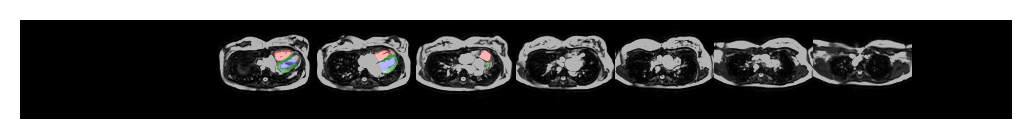

2020-12-01 18:04:49,109 INFO GT on AX


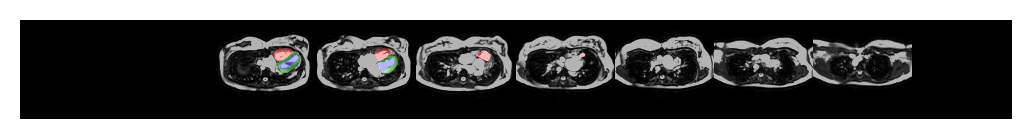

2020-12-01 18:04:49,590 INFO inv mask shape: (27, 256, 256, 4), gt mask shape: (27, 256, 256, 4)
2020-12-01 18:04:49,598 INFO DICE LV: 0.8483765125274658
2020-12-01 18:04:49,607 INFO DICE RV: 0.7949174642562866
2020-12-01 18:04:49,614 INFO DICE MYO: 0.7622656226158142
2020-12-01 18:04:49,657 INFO m: [[ 0.4756 -0.8223 -0.3125 -0.999 ]
 [ 0.3389 -0.1567  0.9277 -0.993 ]
 [-0.812  -0.5474  0.204  14.78  ]]
2020-12-01 18:04:49,658 INFO m_mod: [[ 0.4756 -0.8223 -0.3125 -0.572 ]
 [ 0.3389 -0.1567  0.9277 -0.5312]
 [-0.812  -0.5474  0.204   1.862 ]]
2020-12-01 18:04:49,658 INFO m_scaled: [[ 0.4756 -0.8223 -0.3125 -1.144 ]
 [ 0.3389 -0.1567  0.9277 -1.0625]
 [-0.812  -0.5474  0.204   3.725 ]]
2020-12-01 18:04:49,659 INFO 0000-CK8JTQLW_2005-08-08_ED_msk.nrrd
2020-12-01 18:04:54,369 INFO DICE LV: 0.9181686043739319
2020-12-01 18:04:54,436 INFO DICE RV: 0.8780274987220764
2020-12-01 18:04:54,502 INFO DICE MYO: 0.7022859454154968
2020-12-01 18:04:54,973 INFO Predicted mask rotated to AX on origina

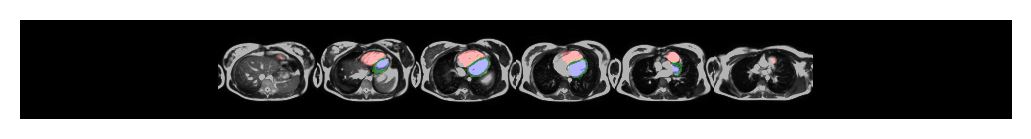

2020-12-01 18:04:55,364 INFO GT on AX


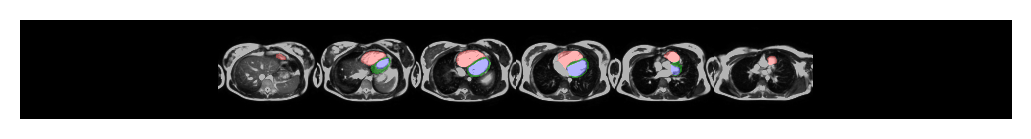

2020-12-01 18:04:55,808 INFO inv mask shape: (16, 256, 256, 4), gt mask shape: (16, 256, 256, 4)
2020-12-01 18:04:55,813 INFO DICE LV: 0.9232173562049866
2020-12-01 18:04:55,818 INFO DICE RV: 0.8827022314071655
2020-12-01 18:04:55,822 INFO DICE MYO: 0.7271040678024292
2020-12-01 18:04:55,862 INFO m: [[ 0.4763 -0.8228 -0.311  -0.999 ]
 [ 0.3389 -0.1552  0.928  -0.993 ]
 [-0.8115 -0.5474  0.2047 14.76  ]]
2020-12-01 18:04:55,862 INFO m_mod: [[ 0.4763 -0.8228 -0.311  -0.5713]
 [ 0.3389 -0.1552  0.928  -0.5303]
 [-0.8115 -0.5474  0.2047  1.859 ]]
2020-12-01 18:04:55,863 INFO m_scaled: [[ 0.4763 -0.8228 -0.311  -1.143 ]
 [ 0.3389 -0.1552  0.928  -1.061 ]
 [-0.8115 -0.5474  0.2047  3.719 ]]
2020-12-01 18:04:55,864 INFO 0000-CK8JTQLW_2005-08-08_ES_msk.nrrd
2020-12-01 18:05:00,571 INFO DICE LV: 0.8805754780769348
2020-12-01 18:05:00,639 INFO DICE RV: 0.8188570141792297
2020-12-01 18:05:00,704 INFO DICE MYO: 0.6975392699241638
2020-12-01 18:05:01,174 INFO Predicted mask rotated to AX on origina

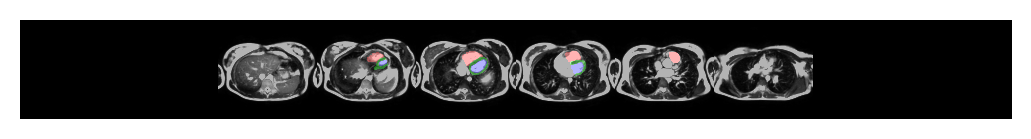

2020-12-01 18:05:01,571 INFO GT on AX


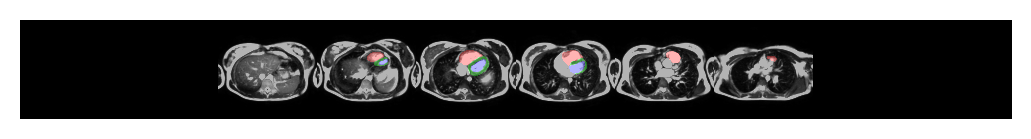

2020-12-01 18:05:02,031 INFO inv mask shape: (16, 256, 256, 4), gt mask shape: (16, 256, 256, 4)
2020-12-01 18:05:02,037 INFO DICE LV: 0.9183647632598877
2020-12-01 18:05:02,043 INFO DICE RV: 0.8228687644004822
2020-12-01 18:05:02,048 INFO DICE MYO: 0.7358787059783936
2020-12-01 18:05:02,088 INFO m: [[ 0.4807 -0.829  -0.2856 -0.999 ]
 [ 0.3367 -0.1267  0.933  -0.992 ]
 [-0.81   -0.545   0.2184 14.47  ]]
2020-12-01 18:05:02,089 INFO m_mod: [[ 0.4807 -0.829  -0.2856 -0.5645]
 [ 0.3367 -0.1267  0.933  -0.5234]
 [-0.81   -0.545   0.2184  1.823 ]]
2020-12-01 18:05:02,089 INFO m_scaled: [[ 0.4807 -0.829  -0.2856 -1.129 ]
 [ 0.3367 -0.1267  0.933  -1.047 ]
 [-0.81   -0.545   0.2184  3.646 ]]
2020-12-01 18:05:02,090 INFO 0000-CT8YR38C_2005-10-25_ED_msk.nrrd
2020-12-01 18:05:06,743 INFO DICE LV: 0.9083519577980042
2020-12-01 18:05:06,825 INFO DICE RV: 0.820669949054718
2020-12-01 18:05:06,898 INFO DICE MYO: 0.6328627467155457
2020-12-01 18:05:07,370 INFO Predicted mask rotated to AX on original

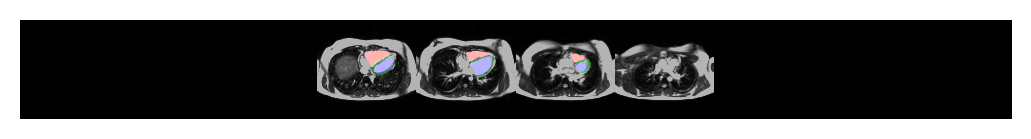

2020-12-01 18:05:07,766 INFO GT on AX


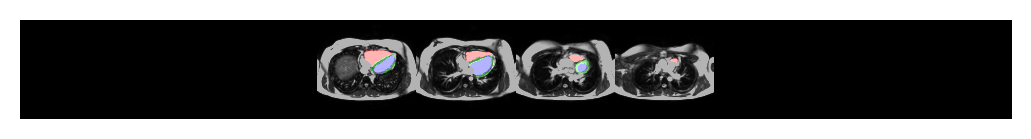

2020-12-01 18:05:08,205 INFO inv mask shape: (16, 256, 256, 4), gt mask shape: (16, 256, 256, 4)
2020-12-01 18:05:08,211 INFO DICE LV: 0.9215946793556213
2020-12-01 18:05:08,216 INFO DICE RV: 0.8290984630584717
2020-12-01 18:05:08,222 INFO DICE MYO: 0.6438557505607605
2020-12-01 18:05:08,271 INFO m: [[ 0.473  -0.8174 -0.3281 -0.999 ]
 [ 0.3398 -0.1738  0.924  -0.9937]
 [-0.8125 -0.549   0.1956 14.95  ]]
2020-12-01 18:05:08,272 INFO m_mod: [[ 0.473  -0.8174 -0.3281 -0.576 ]
 [ 0.3398 -0.1738  0.924  -0.535 ]
 [-0.8125 -0.549   0.1956  1.884 ]]
2020-12-01 18:05:08,272 INFO m_scaled: [[ 0.473  -0.8174 -0.3281 -1.152 ]
 [ 0.3398 -0.1738  0.924  -1.07  ]
 [-0.8125 -0.549   0.1956  3.768 ]]
2020-12-01 18:05:08,273 INFO 0000-CT8YR38C_2005-10-25_ES_msk.nrrd
2020-12-01 18:05:12,961 INFO DICE LV: 0.8295828104019165
2020-12-01 18:05:13,047 INFO DICE RV: 0.7053062319755554
2020-12-01 18:05:13,119 INFO DICE MYO: 0.654391884803772
2020-12-01 18:05:13,604 INFO Predicted mask rotated to AX on original

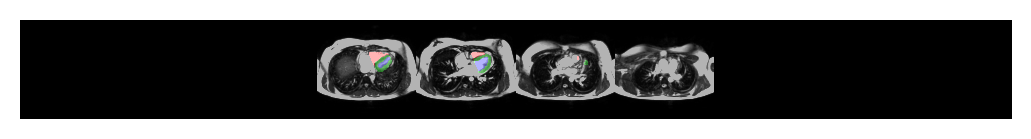

2020-12-01 18:05:13,989 INFO GT on AX


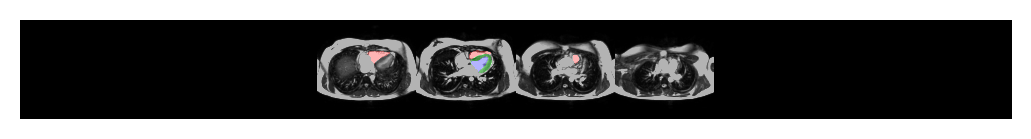

2020-12-01 18:05:14,419 INFO inv mask shape: (16, 256, 256, 4), gt mask shape: (16, 256, 256, 4)
2020-12-01 18:05:14,425 INFO DICE LV: 0.8611233830451965
2020-12-01 18:05:14,430 INFO DICE RV: 0.6795884966850281
2020-12-01 18:05:14,436 INFO DICE MYO: 0.655881404876709
2020-12-01 18:05:14,483 INFO m: [[ 0.4734 -0.8184 -0.3247 -0.999 ]
 [ 0.3394 -0.1705  0.925  -0.9937]
 [-0.8125 -0.5483  0.1971 14.92  ]]
2020-12-01 18:05:14,484 INFO m_mod: [[ 0.4734 -0.8184 -0.3247 -0.575 ]
 [ 0.3394 -0.1705  0.925  -0.5347]
 [-0.8125 -0.5483  0.1971  1.88  ]]
2020-12-01 18:05:14,485 INFO m_scaled: [[ 0.4734 -0.8184 -0.3247 -1.15  ]
 [ 0.3394 -0.1705  0.925  -1.069 ]
 [-0.8125 -0.5483  0.1971  3.76  ]]
2020-12-01 18:05:14,485 INFO 0000-D8RUZJ8N_2006-09-22_ED_msk.nrrd
2020-12-01 18:05:19,146 INFO DICE LV: 0.926306962966919
2020-12-01 18:05:19,236 INFO DICE RV: 0.8262656927108765
2020-12-01 18:05:19,322 INFO DICE MYO: 0.6496386528015137
2020-12-01 18:05:19,826 INFO Predicted mask rotated to AX on original 

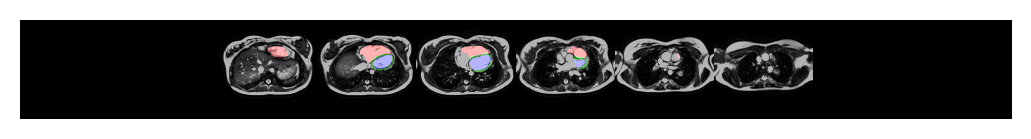

2020-12-01 18:05:20,213 INFO GT on AX


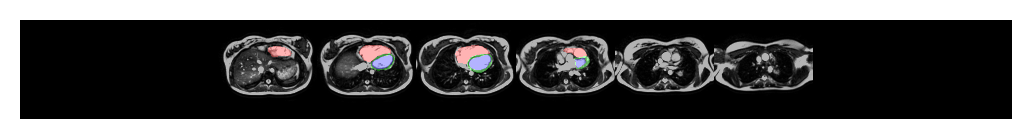

2020-12-01 18:05:20,727 INFO inv mask shape: (23, 256, 256, 4), gt mask shape: (23, 256, 256, 4)
2020-12-01 18:05:20,734 INFO DICE LV: 0.9301410913467407
2020-12-01 18:05:20,741 INFO DICE RV: 0.8339016437530518
2020-12-01 18:05:20,748 INFO DICE MYO: 0.6337797045707703
2020-12-01 18:05:20,803 INFO m: [[ 0.4863 -0.8354 -0.2559 -0.9985]
 [ 0.3347 -0.0925  0.9375 -0.991 ]
 [-0.807  -0.5415  0.2346 14.125 ]]
2020-12-01 18:05:20,803 INFO m_mod: [[ 0.4863 -0.8354 -0.2559 -0.5557]
 [ 0.3347 -0.0925  0.9375 -0.515 ]
 [-0.807  -0.5415  0.2346  1.779 ]]
2020-12-01 18:05:20,804 INFO m_scaled: [[ 0.4863 -0.8354 -0.2559 -1.111 ]
 [ 0.3347 -0.0925  0.9375 -1.03  ]
 [-0.807  -0.5415  0.2346  3.559 ]]
2020-12-01 18:05:20,805 INFO 0000-D8RUZJ8N_2006-09-22_ES_msk.nrrd
2020-12-01 18:05:25,540 INFO DICE LV: 0.840398907661438
2020-12-01 18:05:25,630 INFO DICE RV: 0.7935423254966736
2020-12-01 18:05:25,710 INFO DICE MYO: 0.7289717197418213
2020-12-01 18:05:26,201 INFO Predicted mask rotated to AX on original

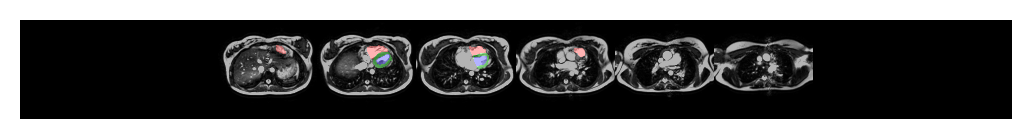

2020-12-01 18:05:26,592 INFO GT on AX


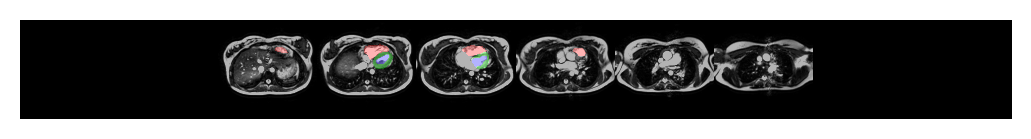

2020-12-01 18:05:27,105 INFO inv mask shape: (23, 256, 256, 4), gt mask shape: (23, 256, 256, 4)
2020-12-01 18:05:27,113 INFO DICE LV: 0.8384985327720642
2020-12-01 18:05:27,119 INFO DICE RV: 0.805290699005127
2020-12-01 18:05:27,127 INFO DICE MYO: 0.7209808230400085
2020-12-01 18:05:27,181 INFO m: [[ 0.4849 -0.8345 -0.2622 -0.9985]
 [ 0.335  -0.0998  0.937  -0.9917]
 [-0.8076 -0.542   0.2311 14.195 ]]
2020-12-01 18:05:27,182 INFO m_mod: [[ 0.4849 -0.8345 -0.2622 -0.557 ]
 [ 0.335  -0.0998  0.937  -0.517 ]
 [-0.8076 -0.542   0.2311  1.788 ]]
2020-12-01 18:05:27,182 INFO m_scaled: [[ 0.4849 -0.8345 -0.2622 -1.114 ]
 [ 0.335  -0.0998  0.937  -1.034 ]
 [-0.8076 -0.542   0.2311  3.576 ]]
2020-12-01 18:05:27,183 INFO 0000-GLGJL3TK_2006-11-17_ED_msk.nrrd
2020-12-01 18:05:31,930 INFO DICE LV: 0.8585543036460876
2020-12-01 18:05:32,019 INFO DICE RV: 0.7624132633209229
2020-12-01 18:05:32,106 INFO DICE MYO: 0.5462925434112549
2020-12-01 18:05:32,610 INFO Predicted mask rotated to AX on original

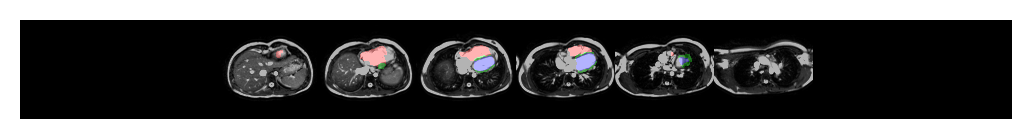

2020-12-01 18:05:33,000 INFO GT on AX


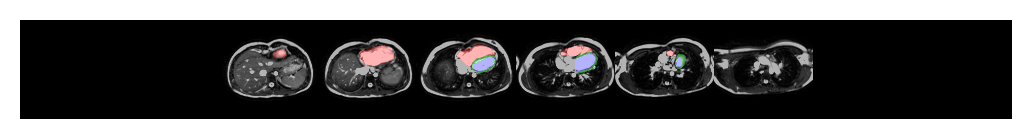

2020-12-01 18:05:33,513 INFO inv mask shape: (23, 256, 256, 4), gt mask shape: (23, 256, 256, 4)
2020-12-01 18:05:33,521 INFO DICE LV: 0.8774638175964355
2020-12-01 18:05:33,528 INFO DICE RV: 0.7743239402770996
2020-12-01 18:05:33,536 INFO DICE MYO: 0.5779016017913818
2020-12-01 18:05:33,591 INFO m: [[ 0.4744 -0.82   -0.3223 -0.999 ]
 [ 0.3394 -0.168   0.926  -0.993 ]
 [-0.8125 -0.5483  0.1984 14.88  ]]
2020-12-01 18:05:33,592 INFO m_mod: [[ 0.4744 -0.82   -0.3223 -0.574 ]
 [ 0.3394 -0.168   0.926  -0.5337]
 [-0.8125 -0.5483  0.1984  1.874 ]]
2020-12-01 18:05:33,592 INFO m_scaled: [[ 0.4744 -0.82   -0.3223 -1.148 ]
 [ 0.3394 -0.168   0.926  -1.067 ]
 [-0.8125 -0.5483  0.1984  3.748 ]]
2020-12-01 18:05:33,594 INFO 0000-GLGJL3TK_2006-11-17_ES_msk.nrrd
2020-12-01 18:05:38,356 INFO DICE LV: 0.7983965277671814
2020-12-01 18:05:38,446 INFO DICE RV: 0.7603124976158142
2020-12-01 18:05:38,525 INFO DICE MYO: 0.6270810961723328
2020-12-01 18:05:39,020 INFO Predicted mask rotated to AX on origina

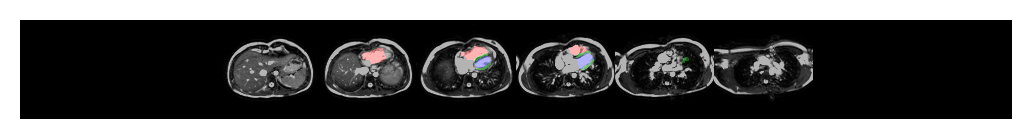

2020-12-01 18:05:39,409 INFO GT on AX


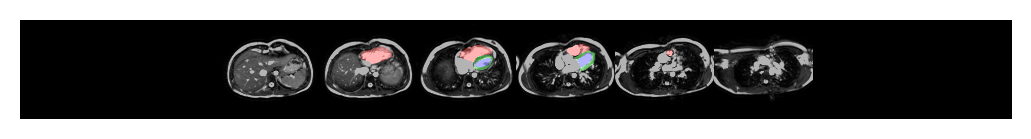

2020-12-01 18:05:39,921 INFO inv mask shape: (23, 256, 256, 4), gt mask shape: (23, 256, 256, 4)
2020-12-01 18:05:39,928 INFO DICE LV: 0.8015456795692444
2020-12-01 18:05:39,935 INFO DICE RV: 0.7691680192947388
2020-12-01 18:05:39,943 INFO DICE MYO: 0.6393325924873352
2020-12-01 18:05:40,000 INFO m: [[ 0.4775 -0.8257 -0.302  -0.999 ]
 [ 0.338  -0.1447  0.93   -0.9927]
 [-0.811  -0.546   0.2098 14.65  ]]
2020-12-01 18:05:40,001 INFO m_mod: [[ 0.4775 -0.8257 -0.302  -0.5684]
 [ 0.338  -0.1447  0.93   -0.5283]
 [-0.811  -0.546   0.2098  1.846 ]]
2020-12-01 18:05:40,001 INFO m_scaled: [[ 0.4775 -0.8257 -0.302  -1.137 ]
 [ 0.338  -0.1447  0.93   -1.057 ]
 [-0.811  -0.546   0.2098  3.691 ]]
2020-12-01 18:05:40,002 INFO 0000-NWFRFC1Z_2006-11-16_ED_msk.nrrd
2020-12-01 18:05:44,748 INFO DICE LV: 0.9051376581192017
2020-12-01 18:05:44,838 INFO DICE RV: 0.8568751215934753
2020-12-01 18:05:44,923 INFO DICE MYO: 0.6519619226455688
2020-12-01 18:05:45,426 INFO Predicted mask rotated to AX on origina

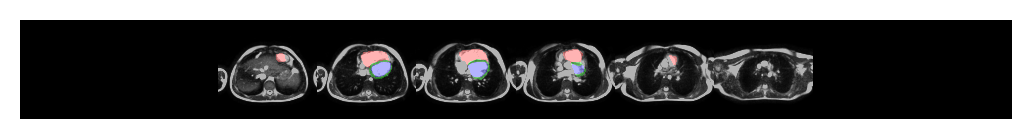

2020-12-01 18:05:45,816 INFO GT on AX


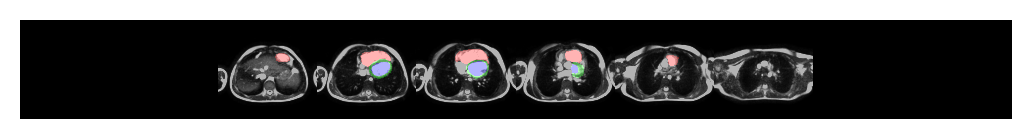

2020-12-01 18:05:46,318 INFO inv mask shape: (24, 256, 256, 4), gt mask shape: (24, 256, 256, 4)
2020-12-01 18:05:46,326 INFO DICE LV: 0.901343822479248
2020-12-01 18:05:46,333 INFO DICE RV: 0.8744773268699646
2020-12-01 18:05:46,340 INFO DICE MYO: 0.6487382650375366
2020-12-01 18:05:46,396 INFO m: [[ 0.4707 -0.813  -0.3435 -0.999 ]
 [ 0.341  -0.1915  0.921  -0.9937]
 [-0.814  -0.5503  0.187  15.125 ]]
2020-12-01 18:05:46,396 INFO m_mod: [[ 0.4707 -0.813  -0.3435 -0.58  ]
 [ 0.341  -0.1915  0.921  -0.5396]
 [-0.814  -0.5503  0.187   1.905 ]]
2020-12-01 18:05:46,397 INFO m_scaled: [[ 0.4707 -0.813  -0.3435 -1.16  ]
 [ 0.341  -0.1915  0.921  -1.079 ]
 [-0.814  -0.5503  0.187   3.81  ]]
2020-12-01 18:05:46,398 INFO 0000-NWFRFC1Z_2006-11-16_ES_msk.nrrd
2020-12-01 18:05:51,270 INFO DICE LV: 0.8230631351470947
2020-12-01 18:05:51,353 INFO DICE RV: 0.8478748798370361
2020-12-01 18:05:51,434 INFO DICE MYO: 0.6918504238128662
2020-12-01 18:05:51,932 INFO Predicted mask rotated to AX on original

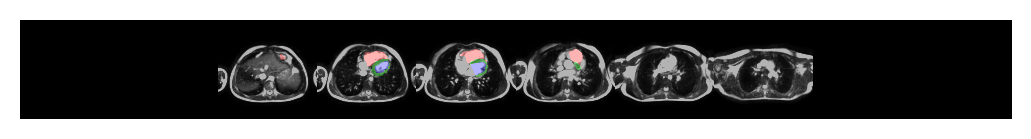

2020-12-01 18:05:52,324 INFO GT on AX


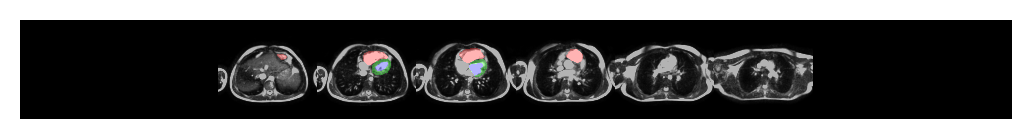

2020-12-01 18:05:52,842 INFO inv mask shape: (24, 256, 256, 4), gt mask shape: (24, 256, 256, 4)
2020-12-01 18:05:52,850 INFO DICE LV: 0.8299806118011475
2020-12-01 18:05:52,857 INFO DICE RV: 0.8577483296394348
2020-12-01 18:05:52,864 INFO DICE MYO: 0.6992036700248718
2020-12-01 18:05:52,922 INFO m: [[ 0.4744 -0.82   -0.3223 -0.999 ]
 [ 0.3394 -0.168   0.926  -0.993 ]
 [-0.8125 -0.5483  0.1984 14.875 ]]
2020-12-01 18:05:52,922 INFO m_mod: [[ 0.4744 -0.82   -0.3223 -0.574 ]
 [ 0.3394 -0.168   0.926  -0.5337]
 [-0.8125 -0.5483  0.1984  1.873 ]]
2020-12-01 18:05:52,923 INFO m_scaled: [[ 0.4744 -0.82   -0.3223 -1.148 ]
 [ 0.3394 -0.168   0.926  -1.067 ]
 [-0.8125 -0.5483  0.1984  3.746 ]]


In [19]:
# predict on all test images, once with postprocessing, and once without
use_modified_translation = FOCUS_LOSS # True, if we use the unet extension to learn a second set of translation parameters
combine = False
dual_model = False
experiment_identifier = 'tests_72_112_112_sp3_1ax_1sax_1focus_thres08_inpl_f0_2nd_unet_round_crop'

logging.info('use modified translation to scale: {}'.format(use_modified_translation))
path_1 = 'data/predicted/{}/3D/'.format(experiment_identifier)
path_2 = path_1.replace('_post', '_NoPost')

# make predictions with different parameters in the same flow
for i in range(ax_full.shape[0]):
    select_image_in_batch_(im=i,slice_n=5, debug=False,export_path=path_1, save=True, postprocess=True, use_mod_translation=use_modified_translation, combine=combine, dual_model=dual_model)
    #select_image_in_batch_(im=i,slice_n=5, debug=False,export_path=path_1, save=True, postprocess=False, use_mod_translation=use_modified_translation, combine=combine, dual_model=dual_model)

In [ ]:
# Initial version, please check before execute
assert(False==True)
@interact
def select_image_in_batch(im=(0, x_.shape[0] - 1, 1), 
                          slice_n=(1, 6), 
                          export_path='data/predicted/temp/',
                          shift_z=20,
                          debug=False,
                         save=False):
    """
    Use the spatial transformer to rotate, predict segmentations, reverse the rotation on the masks and save the nrrd files (image, gt and pred)
    :param im: slider to select another image from the generator
    :param slice_n: The show_2D_3D method slices to a maximum of 20 slices in z, this parameter allows to further slice the visualisations
    :param export_path: path to save the img, gt and prediction volumes as nrrd file, the file names will be the same as in x_ax_val...
    :param debug: bool to enable plotting of the intermediate steps
    :return: void
    """
    global m

    full_file_name = y_val_ax[im]
    filename = os.path.basename(full_file_name)
    logging.info(filename)
    temp = x_[im]
    temp_ = y_[im]
    ax_full_ = ax_full[im]
    ax_msk_full_gt = ax_msk_[im]
    
    # define a different logging level to make the generator steps visible
    logging.getLogger().setLevel(logging.INFO)
    logging.info('Prediction on AX volume:')
    if debug: show_2D_or_3D(temp[::slice_n])
    plt.show()
    
    # Predict rotation of AX and get transformation matrix
    logging.info('AX --> SAX rotated by the model')
    pred, m, mask_pred= model.predict(np.expand_dims(temp, axis=0))
    if debug: show_2D_or_3D(pred[0][::slice_n])
    plt.show()
    
    # make copy of m for reusage
    #m_ = m.copy()
    m = np.reshape(m, (3,4))
    # scale translation part of the affine matrix from spacing 5 to 1.5
    m_t = m[:,3]
    m_t = (m_t *5)/1.5
    m[:,3] = m_t
    m_ = m.flatten()
    
    # show the target AXtoSAX volume
    logging.getLogger().setLevel(logging.INFO)
    logging.info('Target (SAX):')
    if debug: show_2D_or_3D(temp_[::slice_n])
    plt.show()
    
    # Repeat the transformation on ax with full resolution
    logging.info('Repeat the transformation on the full resolution')
    logging.getLogger().setLevel(logging.ERROR)
    transformer = create_affine_transformer_fixed(config=msk_cfg, interp_method='linear')
    pred, m_ = transformer.predict(x=[np.expand_dims(ax_full_, axis=0), np.expand_dims(m_,axis=0)])
    if debug: show_2D_or_3D(pred[0][::slice_n*3])
    plt.show()
    
    # reshape m to matrix
    m = np.reshape(m, (3, 4))

    # create a square ident matrix slice m into it
    m_matrix = np.identity(4)
    # slice m (3,4) into identity (4,4)
    m_matrix[:3, :] = m
    # calc inverse, flatten the matrix and cut off the last row for the spatial transformer
    m_matrix_inverse = np.linalg.inv(m_matrix)
    m_matrix_inverse_flatten = m_matrix_inverse.flatten()[:-4]

    # apply the inverse to our AXtoSAX volume
    logging.getLogger().setLevel(logging.INFO)
    logging.info('Apply the invers rotation to our AXtoSAX')
    logging.getLogger().setLevel(logging.ERROR)
    inv, _ = transformer.predict(x=[pred, np.expand_dims(m_matrix_inverse_flatten, axis=0)])
    if debug: show_2D_or_3D(inv[0][::slice_n*3])
    plt.show()

    # load a 3D wrapper model for segmenting the new SAX
    if 'unet' in globals():
        msk = unet.predict(x=pred)
        msk = clean_3d_prediction_3d_cc(from_channel_to_flat(msk[0] >= 0.5))
        msk = transform_to_binary_mask(msk)
        logging.getLogger().setLevel(logging.INFO)
        logging.info('Predicted mask')
        if debug: show_2D_or_3D(pred[0][::slice_n*3], msk[::slice_n*3])
        plt.show()

        # apply inverse to our msk and plot it together with the inverse AXtoSAX
        logging.getLogger().setLevel(logging.ERROR)
        m_transformer = create_affine_transformer_fixed(config=msk_cfg, interp_method='nearest')
        inv_msk = list()
        for c in range(msk.shape[-1]):
            inv_m, _ = m_transformer.predict(
                x=[np.expand_dims(msk[..., c], axis=0), np.expand_dims(m_matrix_inverse_flatten, axis=0)])
            inv_msk.append(inv_m[..., 0] >= 0.5)
        inv_msk = np.stack(inv_msk, axis=-1)
        
        # postprocessing
        logging.getLogger().setLevel(logging.INFO)
        logging.info('Predicted mask rotated to AX on original AX image - before postprocessing')
        if debug: show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[0][::slice_n*3])
        plt.show()
        
        inv_msk = from_channel_to_flat(inv_msk[0])
        kernel = np.ones((5,5),np.uint8)
        kernel_small = np.ones((3,3),np.uint8)
        
        inv_msk = clean_3d_prediction_3d_cc(inv_msk)
        logging.info('Predicted mask rotated to AX on original AX image - after connected component filtering')
        if debug: show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[::slice_n*3])
        plt.show()
        
        inv_msk = np.stack([cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel_small) for img in inv_msk],axis=0)
        logging.info('Predicted mask rotated to AX on original AX image - after closing')
        if debug: show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[::slice_n*3])
        plt.show()
        
        inv_msk = np.stack([cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel, iterations=2) for img in inv_msk],axis=0)
        logging.info('Predicted mask rotated to AX on original AX image - after opening')
        if debug: show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[::slice_n*3])
        plt.show()
        
        inv_msk = np.stack([cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel) for img in inv_msk],axis=0)
        logging.info('Predicted mask rotated to AX on original AX image - after closing')
        if debug: show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[::slice_n*3])
        plt.show()
        
        inv_msk = clean_3d_prediction_3d_cc(inv_msk)
        logging.info('Predicted mask rotated to AX on original AX image - after connected component filtering')
        if debug: show_2D_or_3D(ax_full_, inv_msk)
        plt.show()

        logging.getLogger().setLevel(logging.INFO)
        logging.info('Predicted mask rotated to AX on inverse AXtoSAX')
        if debug: show_2D_or_3D(inv[0][::slice_n*3], inv_msk[::slice_n*3])
        plt.show()
        logging.info('Predicted mask rotated to AX on original AX image')
        show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[::slice_n*3])
        plt.show()
        
        # get the AX target segmentation, processed by the generator to have it in the same shape
        #msk_flatten = clean_3d_prediction_3d_cc(from_channel_to_flat(inv_msk[0]))
        msk_gt_flatten = from_channel_to_flat(ax_msk_full_gt)
        logging.info('GT on AX')
        show_2D_or_3D(ax_full_[::slice_n*3], msk_gt_flatten[::slice_n*3])
        plt.show()
        
        # create a nrrd file for the gt, pred and image volume
        sitk_pred = sitk.GetImageFromArray(inv_msk)
        sitk_ax_img = sitk.GetImageFromArray(ax_full_)
        sitk_ax_msk = sitk.GetImageFromArray(msk_gt_flatten)

        ensure_dir(os.path.join(export_path, 'pred'))
        ensure_dir(os.path.join(export_path, 'image'))
        ensure_dir(os.path.join(export_path, 'gt'))
        
        # load a reference nrrd file, copy all metadata and save the volumes
        reference_sitk = sitk.ReadImage(full_file_name)
        if save:
            copy_meta_and_save(sitk_pred, reference_sitk, os.path.join(export_path, 'pred', filename))
            copy_meta_and_save(sitk_ax_img, reference_sitk,os.path.join(export_path, 'image', filename.replace('msk', 'img')))
            copy_meta_and_save(sitk_ax_msk, reference_sitk, os.path.join(export_path, 'gt', filename))
        # shutil.copyfile(full_file_name, os.path.join(export_path, 'gt', filename))
    else:
        logging.info('no unet in global namespace, segmentation is not possible')

    logging.info('MSE: {}'.format(mse(pred[0], ax_full_).numpy().mean()))
    #logging.info('MSE center cube: {}'.format(metr.cubic_center_loss_wrapper(pred[0], temp_).numpy().mean()))
    try:
        print(np.reshape(m[0], (3, 4)))
    except Exception as e:
        pass


# Further tests, where do our model fail, do we over- or under-segment

In [20]:
gt.shape

(144, 224, 224, 3)

In [21]:
zero = np.zeros_like(gt[...,0:1])
temp = np.concatenate((zero,gt),axis=-1)
temp.shape

(144, 224, 224, 4)

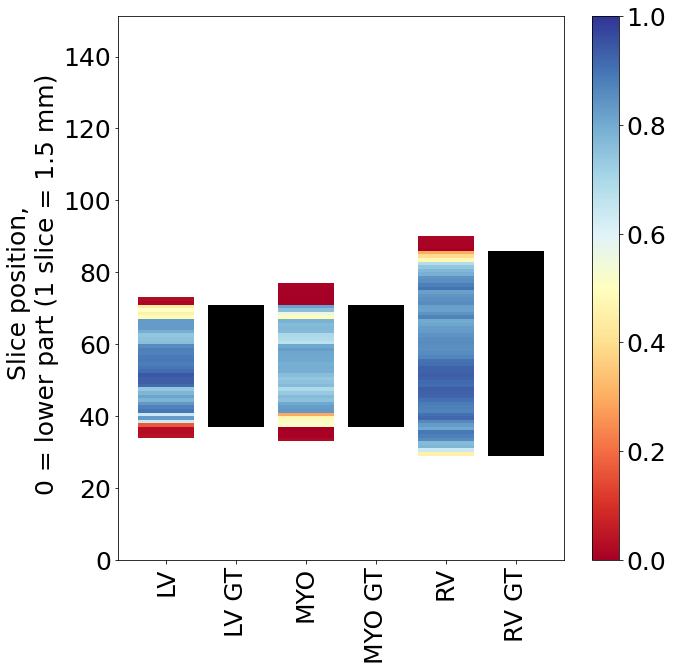

In [22]:
from src.visualization.Visualize import plot_dice_per_slice_bar, plot_dice_per_slice_line
plot_dice_per_slice_bar(gt,pred)

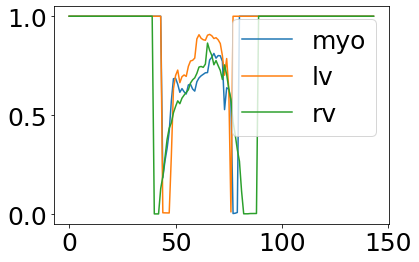

In [31]:
# Create a lineplot for the errors within the volume
plot_dice_per_slice_line(gt,pred)

# Temp tests

In [ ]:
cmap(1)

In [ ]:
# check the memory usage
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)
